# Assignment 2: Backtesting
- Author: Lucas Huynh
- CMU ID: lqh

## 1. Problem Definition

In this assignment, we are tasked with predicting and backtesting the monthly sales of anti-diabetic drugs in Australia. We will use monthly historical sales data from July 1991-June 2008 to build a forecasting model and evaluate its performance by backtesting. Our goal is to evaluate the performance of multiple forecasting models by backtesting 12-month forecasts over four specific test periods:
- July 2004 - June 2005
- July 2005 - June 2006
- July 2006 - June 2007
- July 2007 - June 2008

The overall goal is to predict future sales and compare them against actual sales data. We will implement and evaluate various models, including Exponential Smoothing State Space Models (ETS) and AutoRegressive Integrated Moving Average (ARIMA), over the four test periods. The performance of each model will be assessed through the accuracy of its predictions compared to actual sales data using metrics like RMSE, MAE, MAPE, MASE, and sMAPE. A plot will be created to effectively visualize how each model performed across these test periods, allowing for an intuitive comparison of forecast accuracy. Based on the backtest results, we will select the best-performing model and justify its use for predicting the next 12 months of anti-diabetic drug sales in Australia. The analysis will help assess the model's ability to forecast monthly drug sales, which can inform decision-making in the pharmaceutical industry.

### Read in appropriate packages

In [1]:
import matplotlib.pyplot as plt #viz #GUI manager
import seaborn as sns #viz #plotly is another package
import datetime
import pandas as pd
import numpy as np
from pandas import Grouper #groupby
#statistical data exploration, conducting statistical tests, and estimation of different statistical models
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #autocorrelation plot
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing # double and triple exponential smoothing
from pandas.plotting import autocorrelation_plot #autocorrelation plot
from statsmodels.graphics.gofplots import qqplot #residual diagnostics
from sklearn.metrics import mean_squared_error #accuracy metrics
from math import sqrt
from sklearn.metrics import mean_absolute_error #accuracy metrics

from random import gauss #create gaussian white noise
from random import seed
from pandas import Series

from statsmodels.tsa.stattools import adfuller # Augmented Dickey Fuller test for testing stationarity

from statsmodels.tsa.arima_model import ARIMA #for manual ARIMA

import pmdarima as pm #auto arima

## Exploratory Data Analysis

In [2]:
drug_sales_df = pd.read_csv('drug_sales_australia.csv',
                            parse_dates=['date'],
                            index_col=['date'])
drug_sales_df

value
date                 
1991-07-01   3.526591
1991-08-01   3.180891
1991-09-01   3.252221
1991-10-01   3.611003
1991-11-01   3.565869
...               ...
2008-02-01  21.654285
2008-03-01  18.264945
2008-04-01  23.107677
2008-05-01  22.912510
2008-06-01  19.431740

[204 rows x 1 columns]

In [4]:
drug_sales_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 204 entries, 1991-07-01 to 2008-06-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   204 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


In [5]:
# 1. Descriptive Statistics
drug_sales_df.describe()

value
count  204.000000
mean    10.694430
std      5.956998
min      2.814520
25%      5.844095
50%      9.319345
75%     14.289964
max     29.665356

<Axes: >

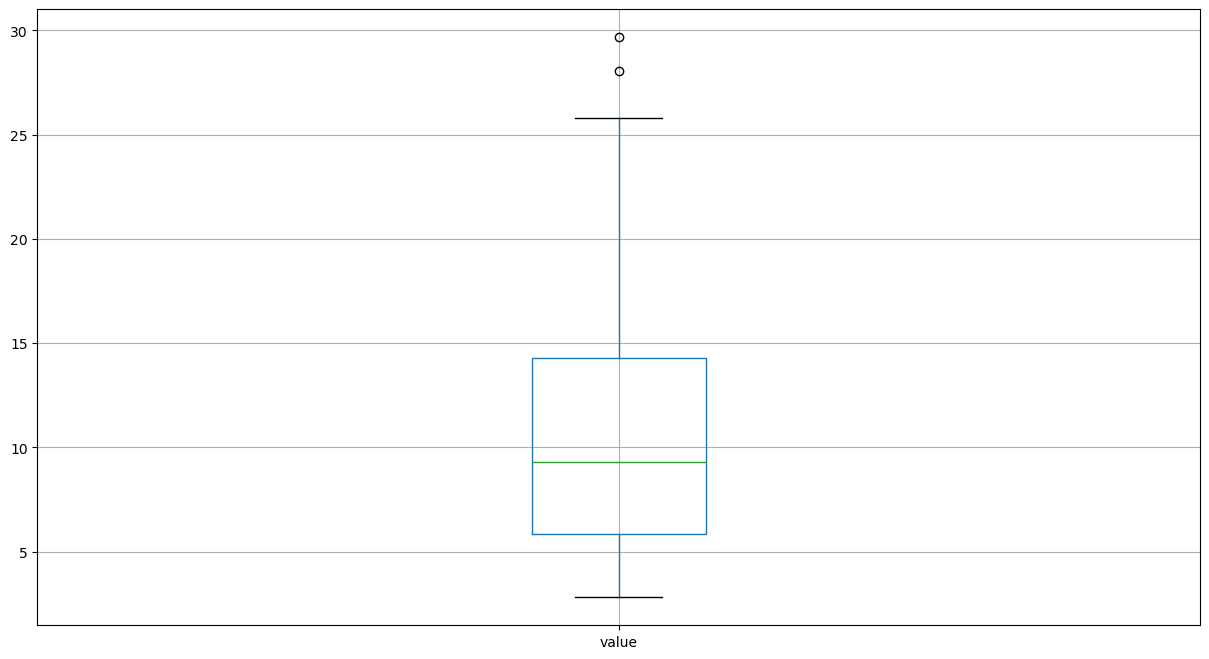

In [6]:
plt.figure(figsize=(15,8))
drug_sales_df.boxplot()

In [7]:
# 2. Check for missing values
drug_sales_df.isnull().sum()

value    0
dtype: int64

In [8]:
# 3. Find the indexes that are missing
pd.date_range(start = drug_sales_df.index.min(), end = drug_sales_df.index.max(), freq='MS').difference(drug_sales_df.index)

DatetimeIndex([], dtype='datetime64[ns]', freq='MS')

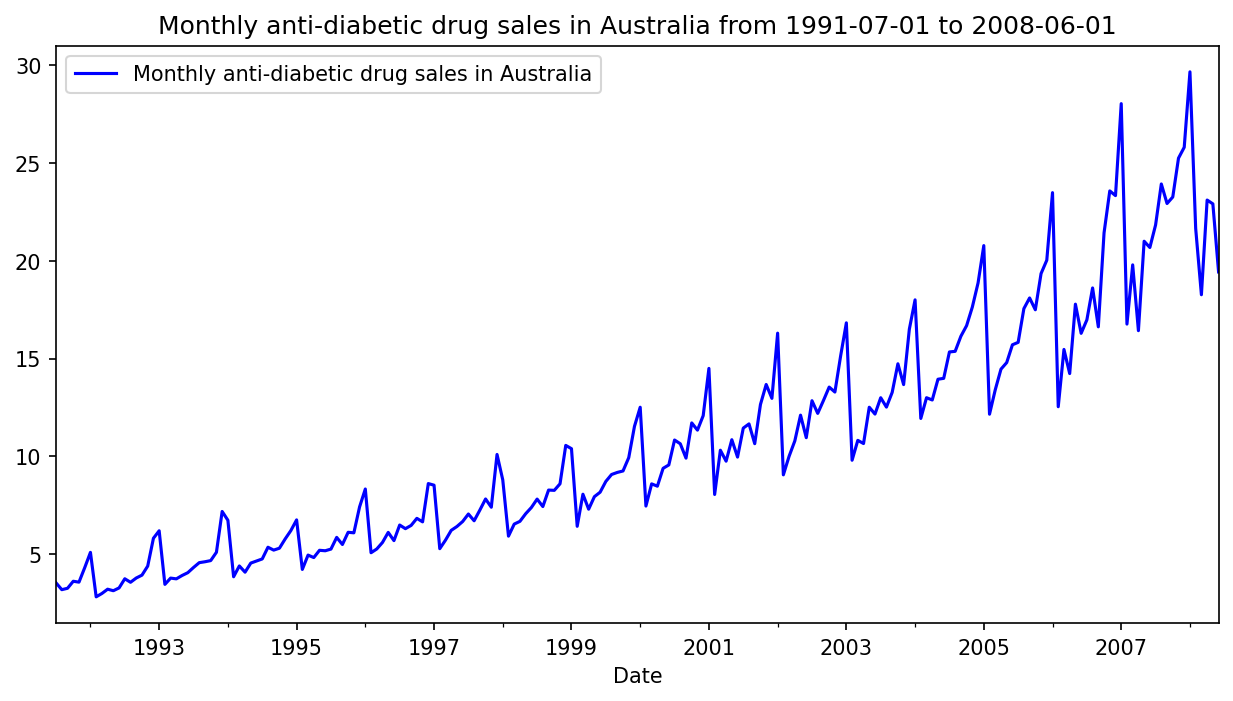

In [3]:
# Visualizing the series

# to set the plot size
plt.figure(figsize=(10, 5), dpi=150) #dpi = resolution. default 100.

# in plot method we set the label and color of the curve.
drug_sales_df['value'].plot(label='Monthly anti-diabetic drug sales in Australia', color='blue')

# adding title to the plot
plt.title('Monthly anti-diabetic drug sales in Australia from {} to {}'.format('1991-07-01', '2008-06-01'))

# adding Label to the x-axis
plt.xlabel('Date')

# adding legend to the curve
plt.legend()

# 2. Create backtest periods

In [9]:
# Define backtest periods
backtest_periods = [
    ("2004-07", "2005-06"),
    ("2005-07", "2006-06"),
    ("2006-07", "2007-06"),
    ("2007-07", "2008-06"),
]

# Create separate DataFrames for each backtest period
backtest_1 = drug_sales_df.loc[backtest_periods[0][0]:backtest_periods[0][1]].copy()
backtest_2 = drug_sales_df.loc[backtest_periods[1][0]:backtest_periods[1][1]].copy()
backtest_3 = drug_sales_df.loc[backtest_periods[2][0]:backtest_periods[2][1]].copy()
backtest_4 = drug_sales_df.loc[backtest_periods[3][0]:backtest_periods[3][1]].copy()

# Print DataFrame summaries
for i, backtest in enumerate([backtest_1, backtest_2, backtest_3, backtest_4], 1):
    print(f"Backtest {i} - Data Range: {backtest.index.min()} to {backtest.index.max()}\n")

Backtest 1 - Data Range: 2004-07-01 00:00:00 to 2005-06-01 00:00:00

Backtest 2 - Data Range: 2005-07-01 00:00:00 to 2006-06-01 00:00:00

Backtest 3 - Data Range: 2006-07-01 00:00:00 to 2007-06-01 00:00:00

Backtest 4 - Data Range: 2007-07-01 00:00:00 to 2008-06-01 00:00:00



# 3. Run Multiple ETS and ARIMA models and evaluate them over the backtest periods

## ETS Models

In [15]:
# Function for backtesting training and testing
def backtest_train_test_graph(data, train_end, test_start, test_end):
    train_data = data.loc[:train_end]
    test_data = data.loc[test_start:test_end]

    #Plot train and test data

    # to set the plot size
    plt.figure(figsize=(16, 8), dpi=150)

    # using plot method to plot close prices.
    # in plot method we set the label and color of the curve.
    train_data['value'].plot(label='Train')
    test_data['value'].plot(label='Test')


    # adding title to the plot
    plt.title('Monthly anti-diabetic drug sales in Australia from {} to {}'.format(test_start, test_end))

    # adding Label to the x-axis
    plt.xlabel('Date')

    # adding legend to the curve
    plt.legend()

In [68]:
#function for ETS models
def exponential_smoothing_backtest(train_data, test_data):
    forecast_period = len(test_data)  # Dynamically determine forecast length

    # Single Exponential Smoothing
    ins1 = SimpleExpSmoothing(train_data).fit(smoothing_level=0.2, optimized=False)
    ins2 = SimpleExpSmoothing(train_data).fit(smoothing_level=0.5, optimized=False)
    ins3 = SimpleExpSmoothing(train_data).fit()

    ins_cast1 = ins1.forecast(forecast_period).rename('alpha=0.2')
    ins_cast2 = ins2.forecast(forecast_period).rename('alpha=0.5')
    ins_cast3 = ins3.forecast(forecast_period).rename(f'alpha={ins3.model.params["smoothing_level"]:.2f}')

    # Plotting Single Exponential Smoothing
    ax = train_data.plot(marker='o', color='black', figsize=(16, 6), legend=True, label="Train Data")
    test_data.plot(marker='o', color='gray', legend=True, label="Test Data")

    ins_cast1.plot(marker='+', ax=ax, color='blue', legend=True)
    ins1.fittedvalues.plot(marker='+', ax=ax, color='blue')

    ins_cast2.plot(marker='o', ax=ax, color='red', legend=True)
    ins2.fittedvalues.plot(marker='o', ax=ax, color='red')

    ins_cast3.plot(marker='*', ax=ax, color='green', legend=True)
    ins3.fittedvalues.plot(marker='*', ax=ax, color='green')

    plt.title('Single Exponential Smoothing Forecast')
    plt.show()

    # Double Exponential Smoothing
    double_ets_add = ExponentialSmoothing(train_data, trend='add').fit()
    double_ets_mul = ExponentialSmoothing(train_data, trend='mul').fit()

    double_ets_add_pred = double_ets_add.forecast(forecast_period)
    double_ets_mul_pred = double_ets_mul.forecast(forecast_period)

    # Plotting Double Exponential Smoothing
    ax = train_data.plot(marker='o', color='black', figsize=(16, 6), legend=True, label="Train Data")
    test_data.plot(marker='o', color='gray', legend=True, label="Test Data")

    double_ets_add_pred.plot(marker='+', ax=ax, color='blue', legend=True, label="Double ETS Additive")
    double_ets_add.fittedvalues.plot(marker='+', ax=ax, color='blue')

    double_ets_mul_pred.plot(marker='o', ax=ax, color='red', legend=True, label="Double ETS Multiplicative")
    double_ets_mul.fittedvalues.plot(marker='o', ax=ax, color='red')

    plt.title('Double Exponential Smoothing Forecast')
    plt.show()

    # Triple Exponential Smoothing (Holt-Winters)
    triple_ets_add = ExponentialSmoothing(train_data, trend='add', seasonal='add', seasonal_periods=12).fit()
    triple_ets_mul = ExponentialSmoothing(train_data, trend='mul', seasonal='mul', seasonal_periods=12).fit()

    triple_ets_add_pred = triple_ets_add.forecast(forecast_period)
    triple_ets_mul_pred = triple_ets_mul.forecast(forecast_period)

    # Plotting Triple Exponential Smoothing
    ax = train_data.plot(marker='o', color='black', figsize=(16, 6), legend=True, label="Train Data")
    test_data.plot(marker='o', color='gray', legend=True, label="Test Data")

    triple_ets_add_pred.plot(marker='+', ax=ax, color='blue', legend=True, label="Triple ETS Additive")
    triple_ets_add.fittedvalues.plot(marker='+', ax=ax, color='blue')

    triple_ets_mul_pred.plot(marker='o', ax=ax, color='red', legend=True, label="Triple ETS Multiplicative")
    triple_ets_mul.fittedvalues.plot(marker='o', ax=ax, color='red')

    plt.title('Triple Exponential Smoothing Forecast (Holt-Winters)')
    plt.show()

     # Calculate residuals (actual - predicted)
    residuals = test_data.values.flatten() - triple_ets_add_pred.values.flatten()
    residuals = pd.DataFrame(residuals, columns=["Residuals"])
    
    # ACF Plot
    fig = plot_acf(residuals)
    fig.set_size_inches((20, 10))
    fig.tight_layout()
    plt.title(f"Autocorrelation of Residuals")
    plt.show()

    # Residual Plot
    residuals.plot(title=f"Residuals Over Time")
    plt.show()

    # Histogram Plot
    residuals.hist(bins=20, edgecolor='black')
    plt.title(f"Residuals Histogram")
    plt.show()

    # Density Plot
    residuals.plot(kind='kde', title=f"Residual Density Plot")
    plt.show()

    # QQ Plot
    qqplot(residuals, line='s')
    plt.title(f"QQ Plot of Residuals")
    plt.show()

   # Define metrics function
    def metrics_cal(actuals, predictions, model):
        mse = mean_squared_error(actuals, predictions)
        rmse = sqrt(mse)
        mae = mean_absolute_error(actuals, predictions)
        mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100

        return pd.DataFrame({
            'Model': [model],
            'RMSE': [rmse],
            'MAE': [mae],
            'MAPE': [mape]
        })

    # Compute metrics
    actual_values = test_data.values.flatten()
    metrics_dataframe = pd.concat([
        metrics_cal(actual_values, ins_cast1.values.flatten(), 'Simple 0.2'),
        metrics_cal(actual_values, ins_cast2.values.flatten(), 'Simple 0.5'),
        metrics_cal(actual_values, ins_cast3.values.flatten(), f"Simple {ins3.model.params['smoothing_level']:.2f}"),
        metrics_cal(actual_values, double_ets_add_pred.values.flatten(), 'Double Add'),
        metrics_cal(actual_values, double_ets_mul_pred.values.flatten(), 'Double Mul'),
        metrics_cal(actual_values, triple_ets_add_pred.values.flatten(), 'Triple Add'),
        metrics_cal(actual_values, triple_ets_mul_pred.values.flatten(), 'Triple Mul')
    ], ignore_index=True)

    return metrics_dataframe.sort_values(by='MAE')




### Backtest Range 1 (July 2004 to June 2005)

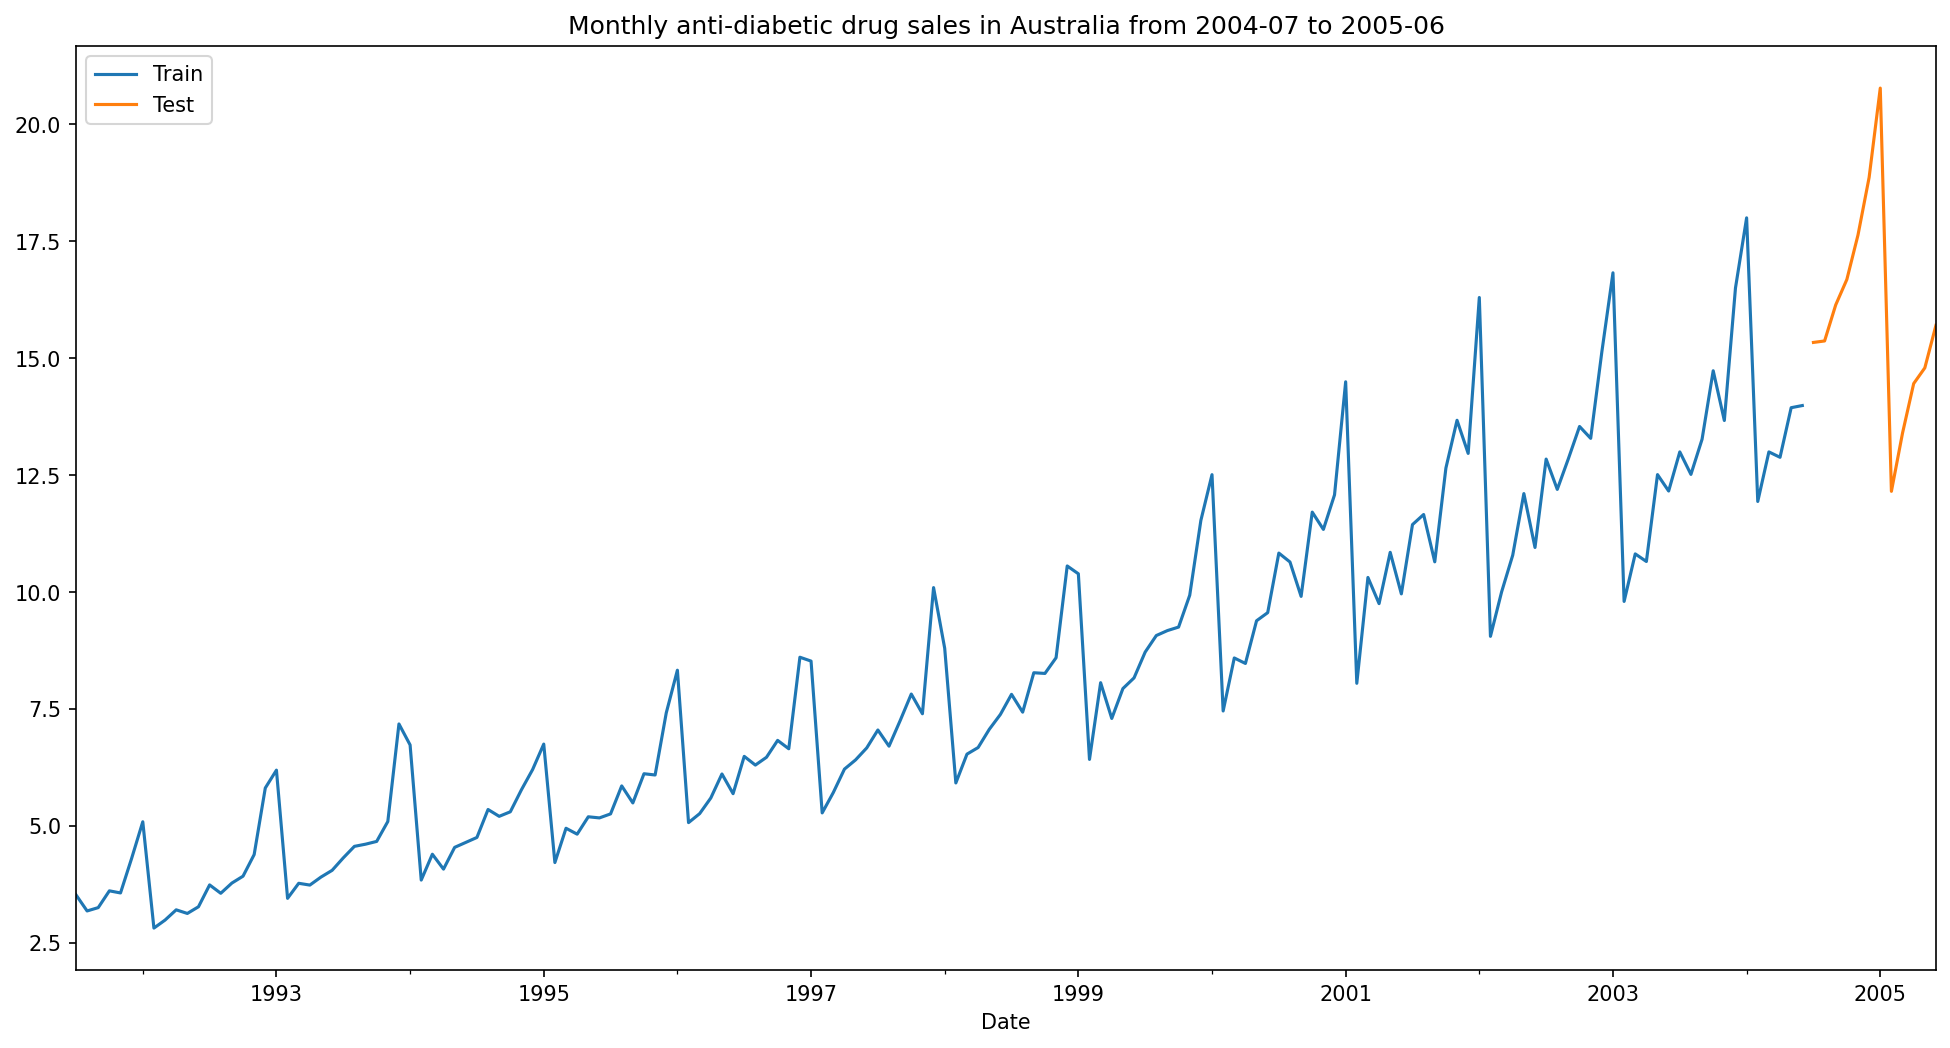

In [69]:
backtest_train_test_graph(drug_sales_df, train_end='2004-06', test_start='2004-07', test_end='2005-06')

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


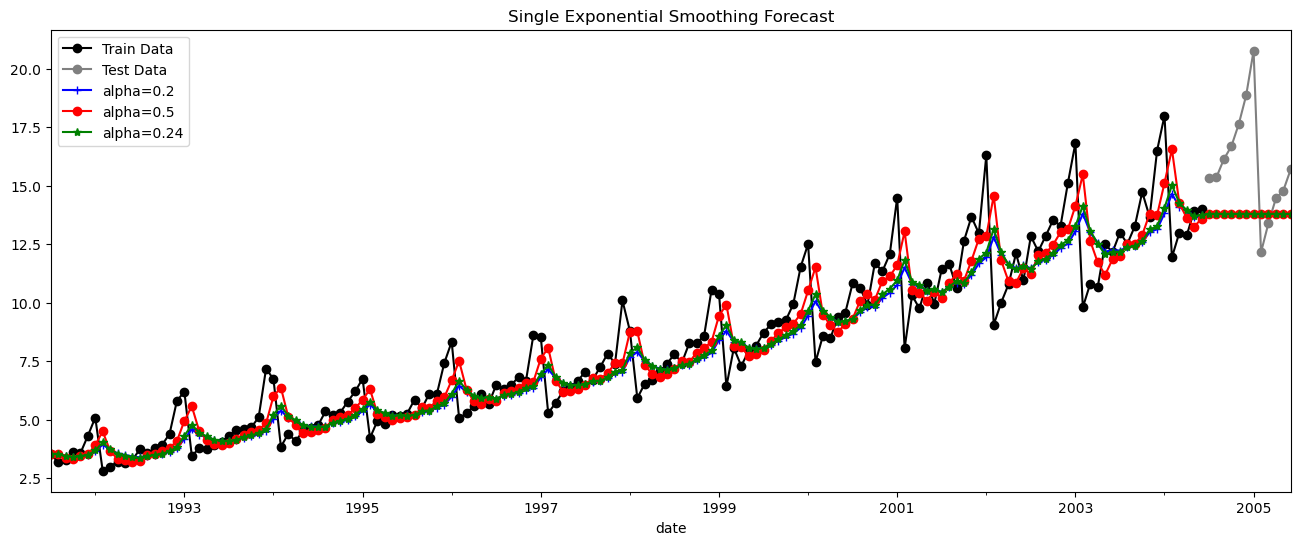

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


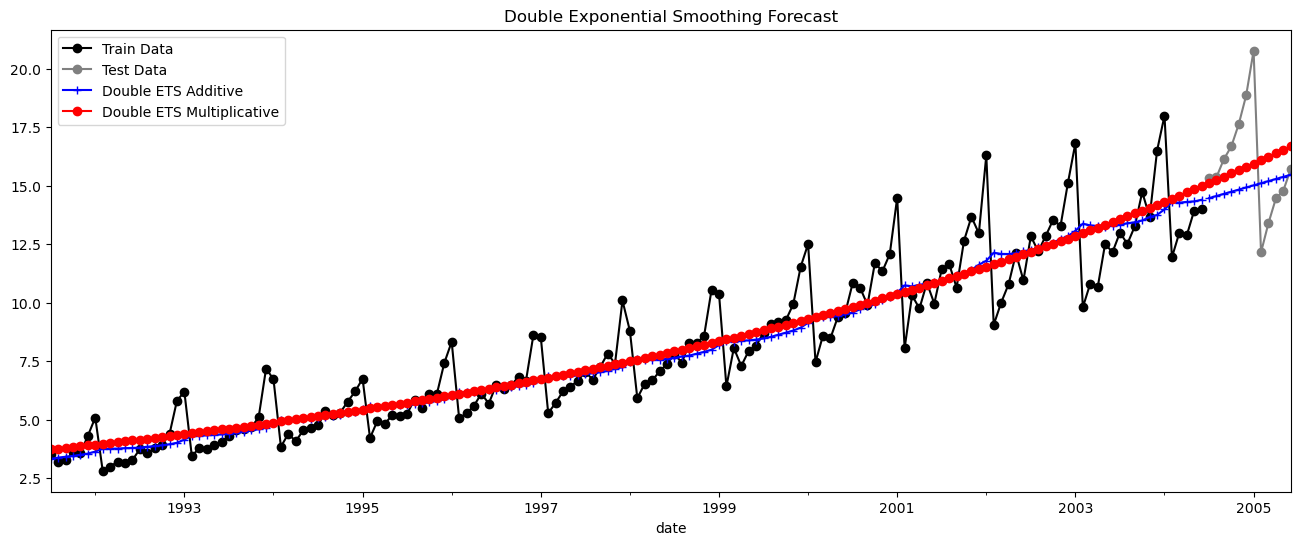

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


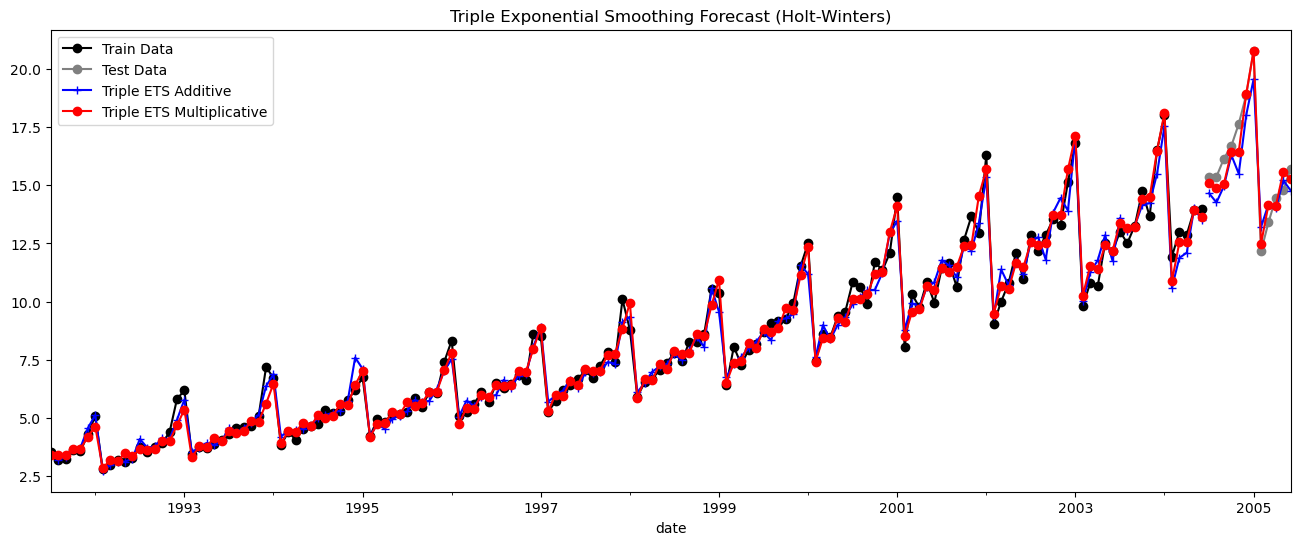

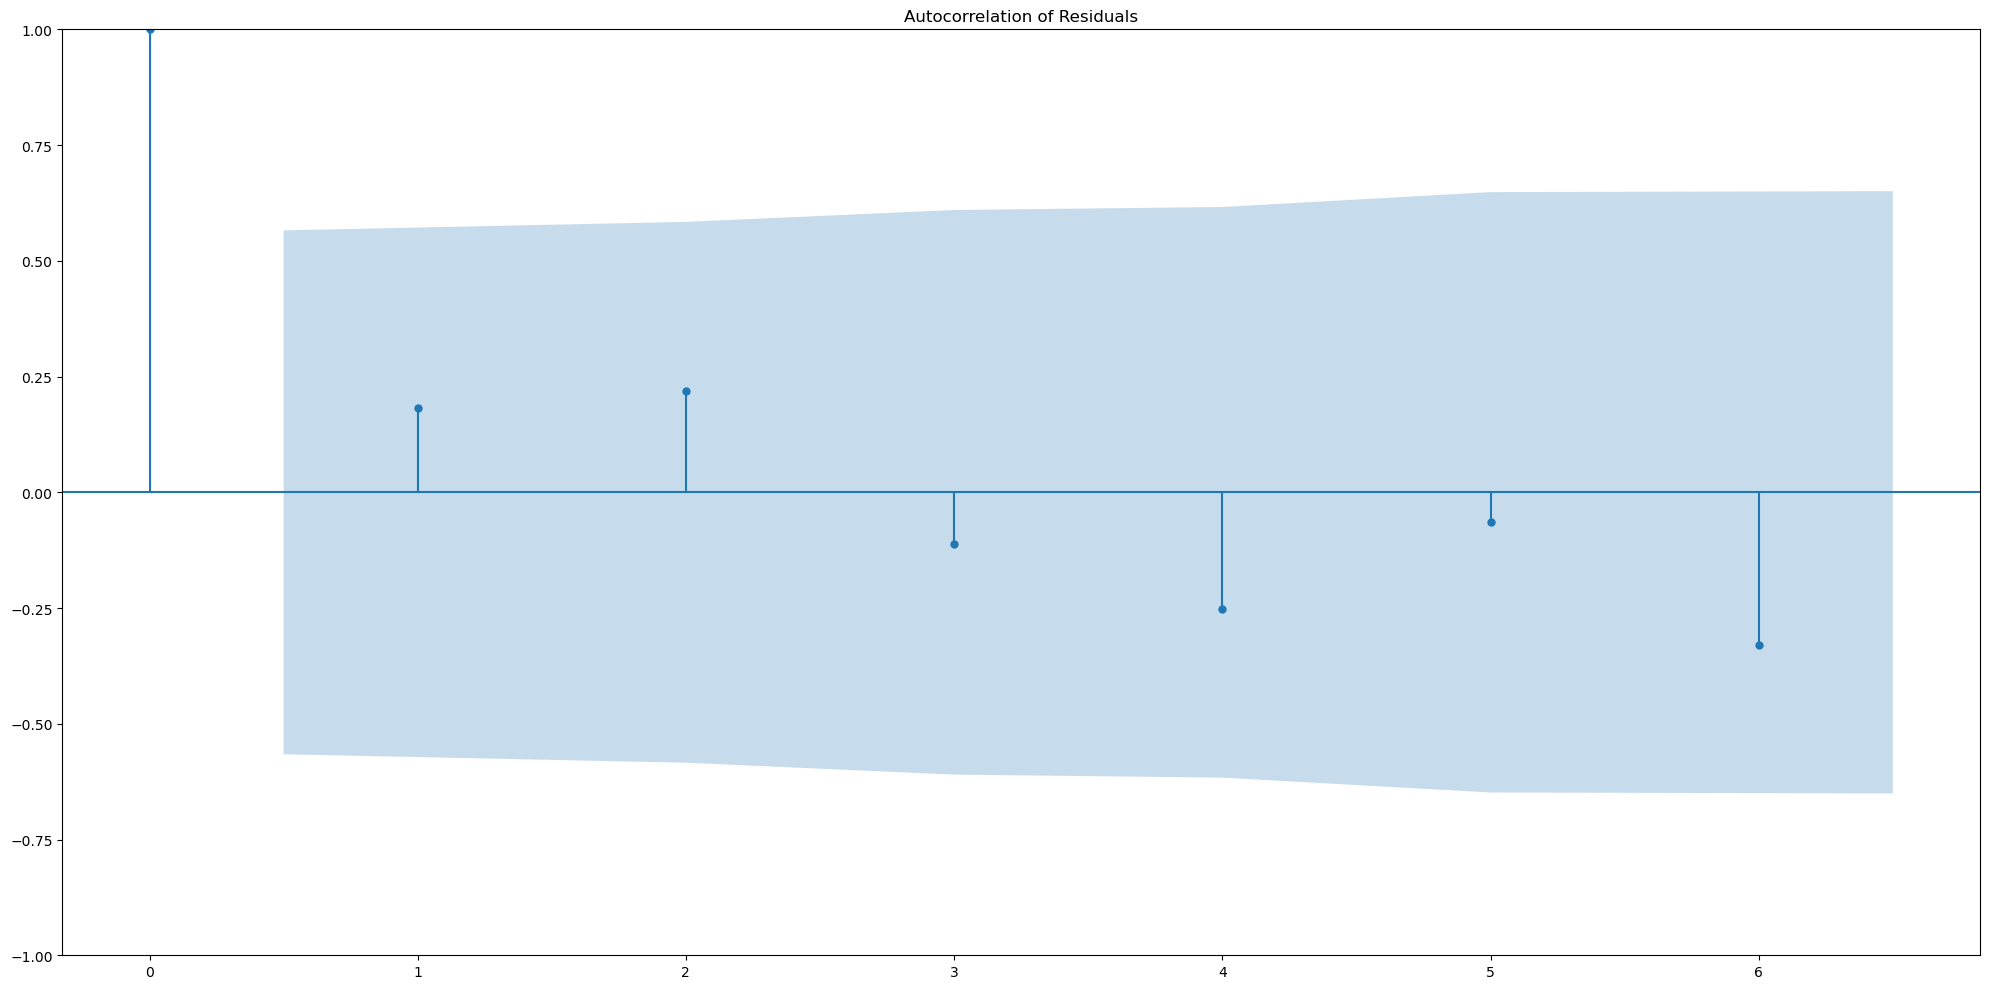

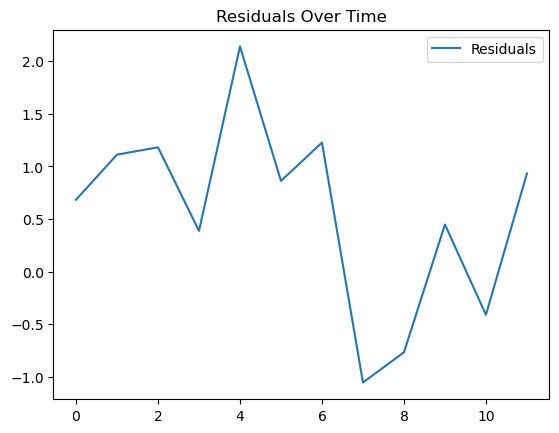

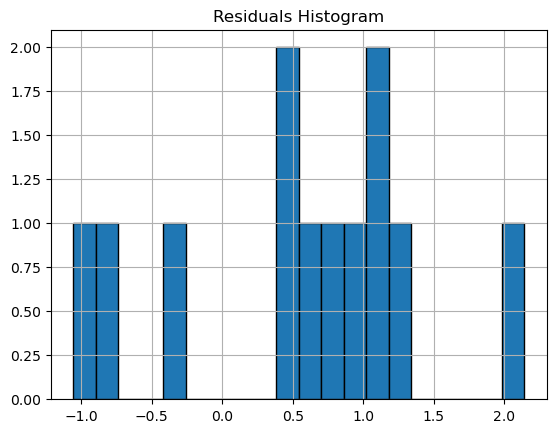

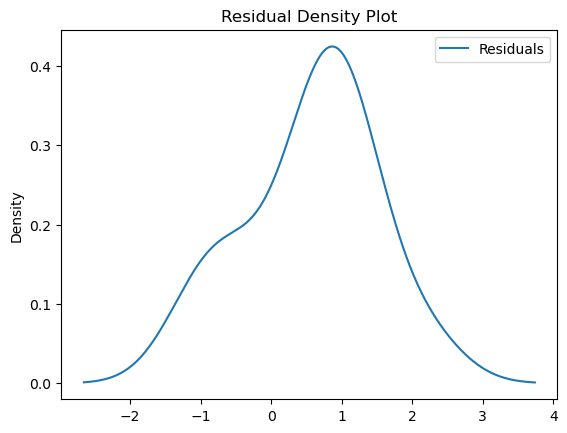

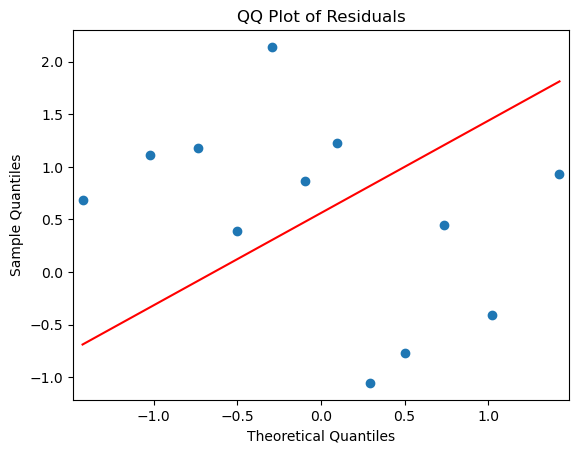

Model      RMSE       MAE       MAPE
6   Triple Mul  0.620139  0.500335   3.258752
5   Triple Add  1.041147  0.933409   5.843408
4   Double Mul  2.411873  1.961102  12.448462
3   Double Add  2.532282  1.999902  12.092792
2  Simple 0.24  3.096008  2.476756  14.466126
1   Simple 0.5  3.109151  2.489451  14.538088
0   Simple 0.2  3.112878  2.493040  14.558432

In [38]:
# Define backtest_1 range
train_end = '2004-06'   # Training data up to June 2004
test_start = '2004-07'  # Test data starts from July 2004
test_end = '2005-06'    # Test data ends in June 2005

# Extract train and test data
train_data = drug_sales_df.loc[:train_end, 'value']
test_data = drug_sales_df.loc[test_start:test_end, 'value']

# Call the function for backtest_1
exponential_smoothing_backtest(train_data, test_data)

### Backtest Range 2 (July 2005 to June 2006)

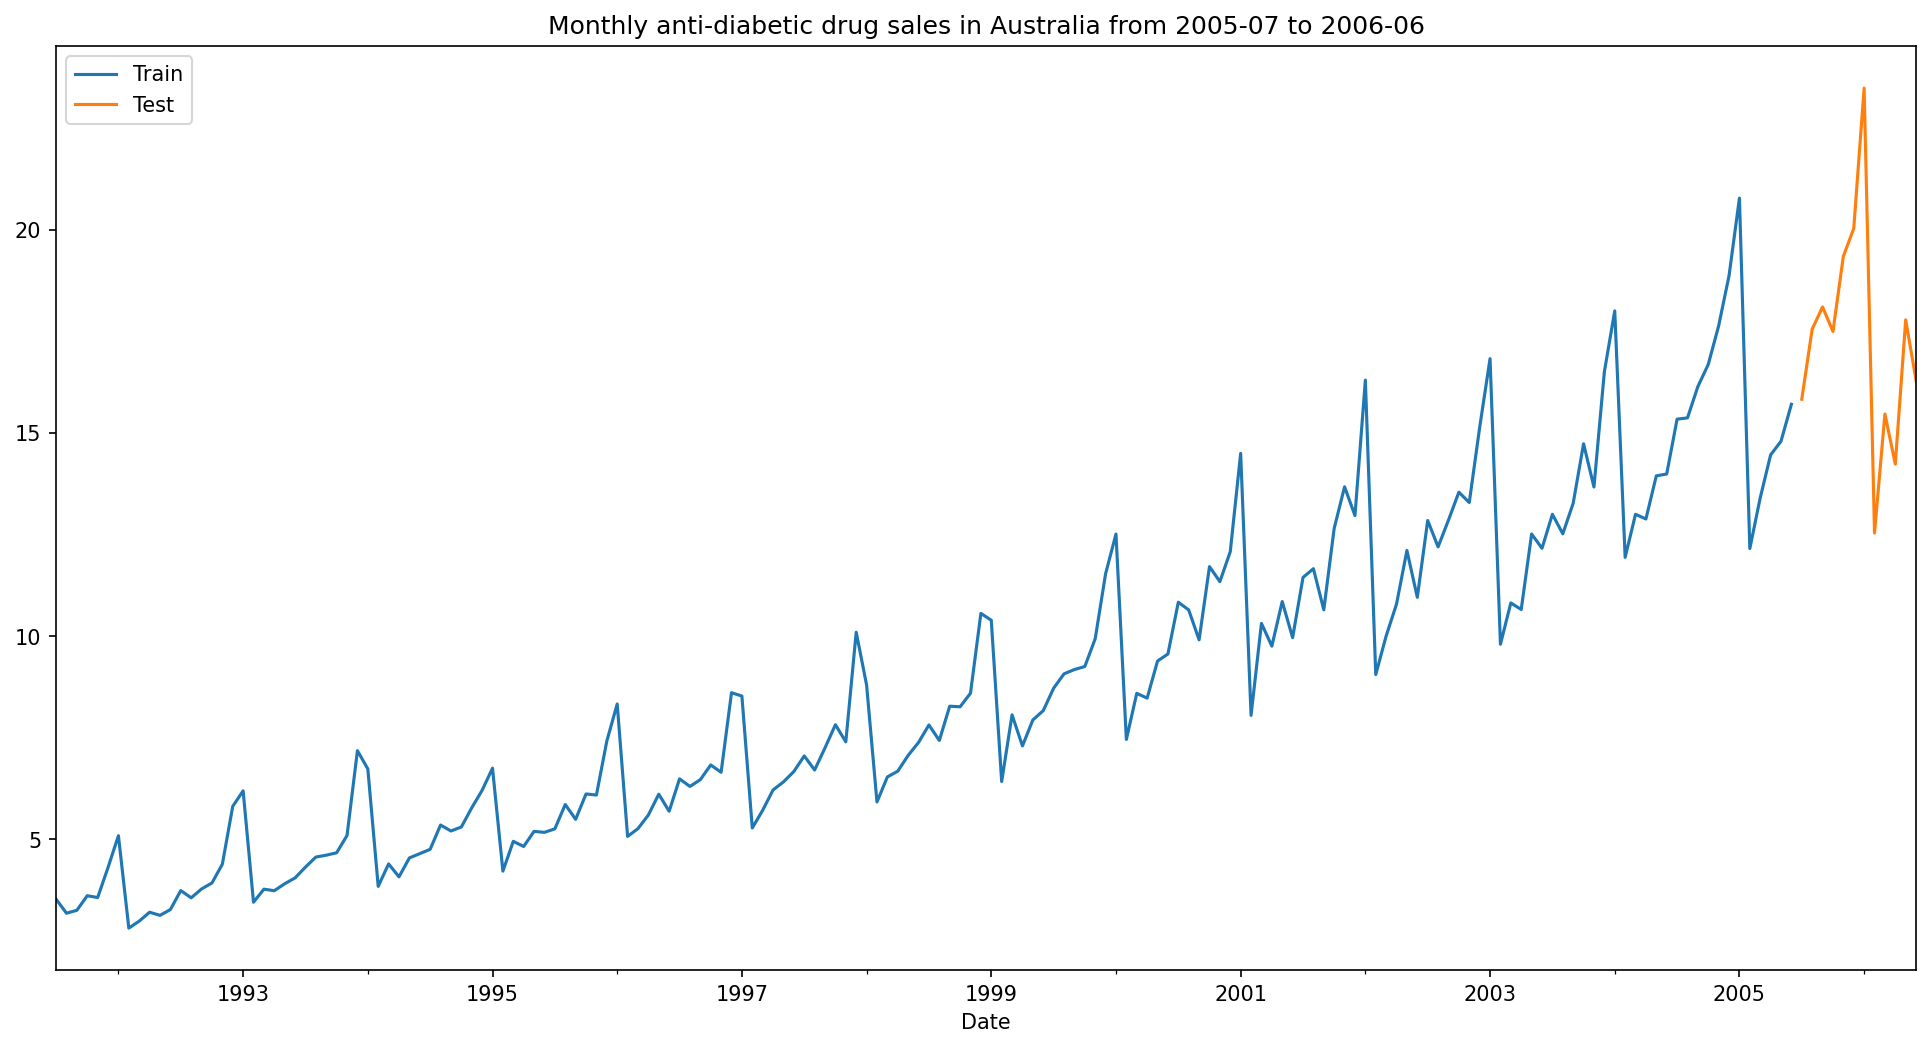

In [39]:
backtest_train_test_graph(drug_sales_df, train_end='2005-06', test_start='2005-07', test_end='2006-06')

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


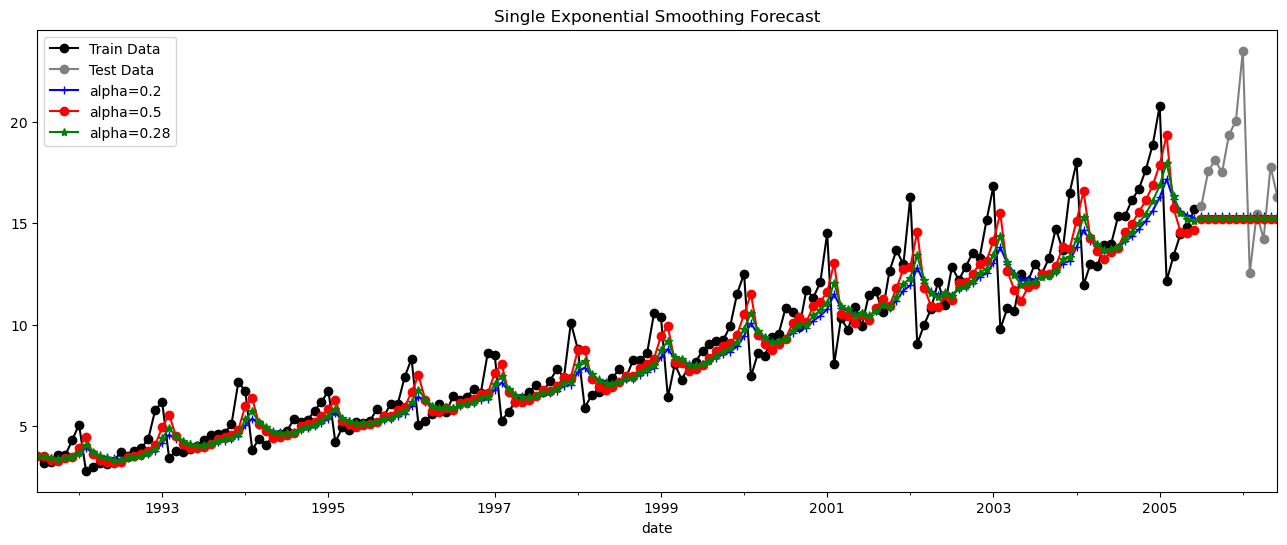

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


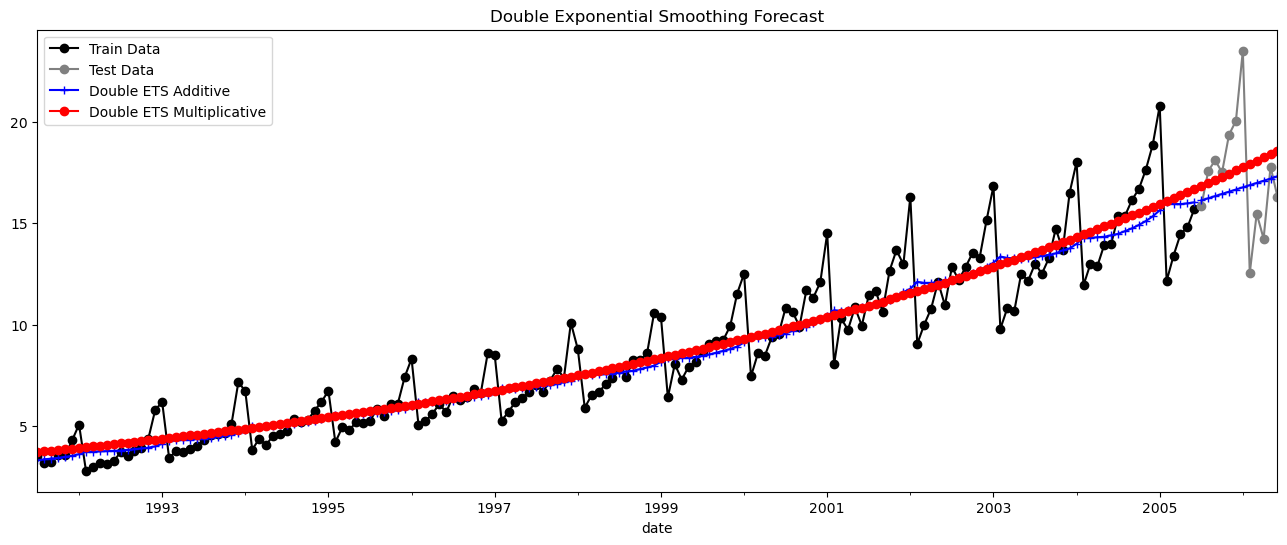

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


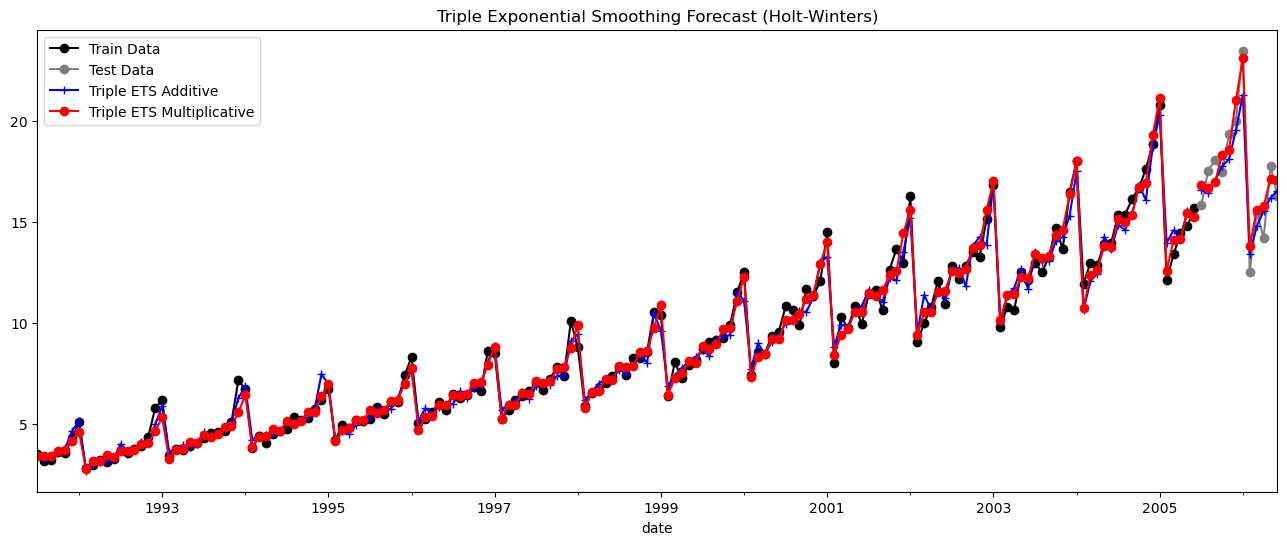

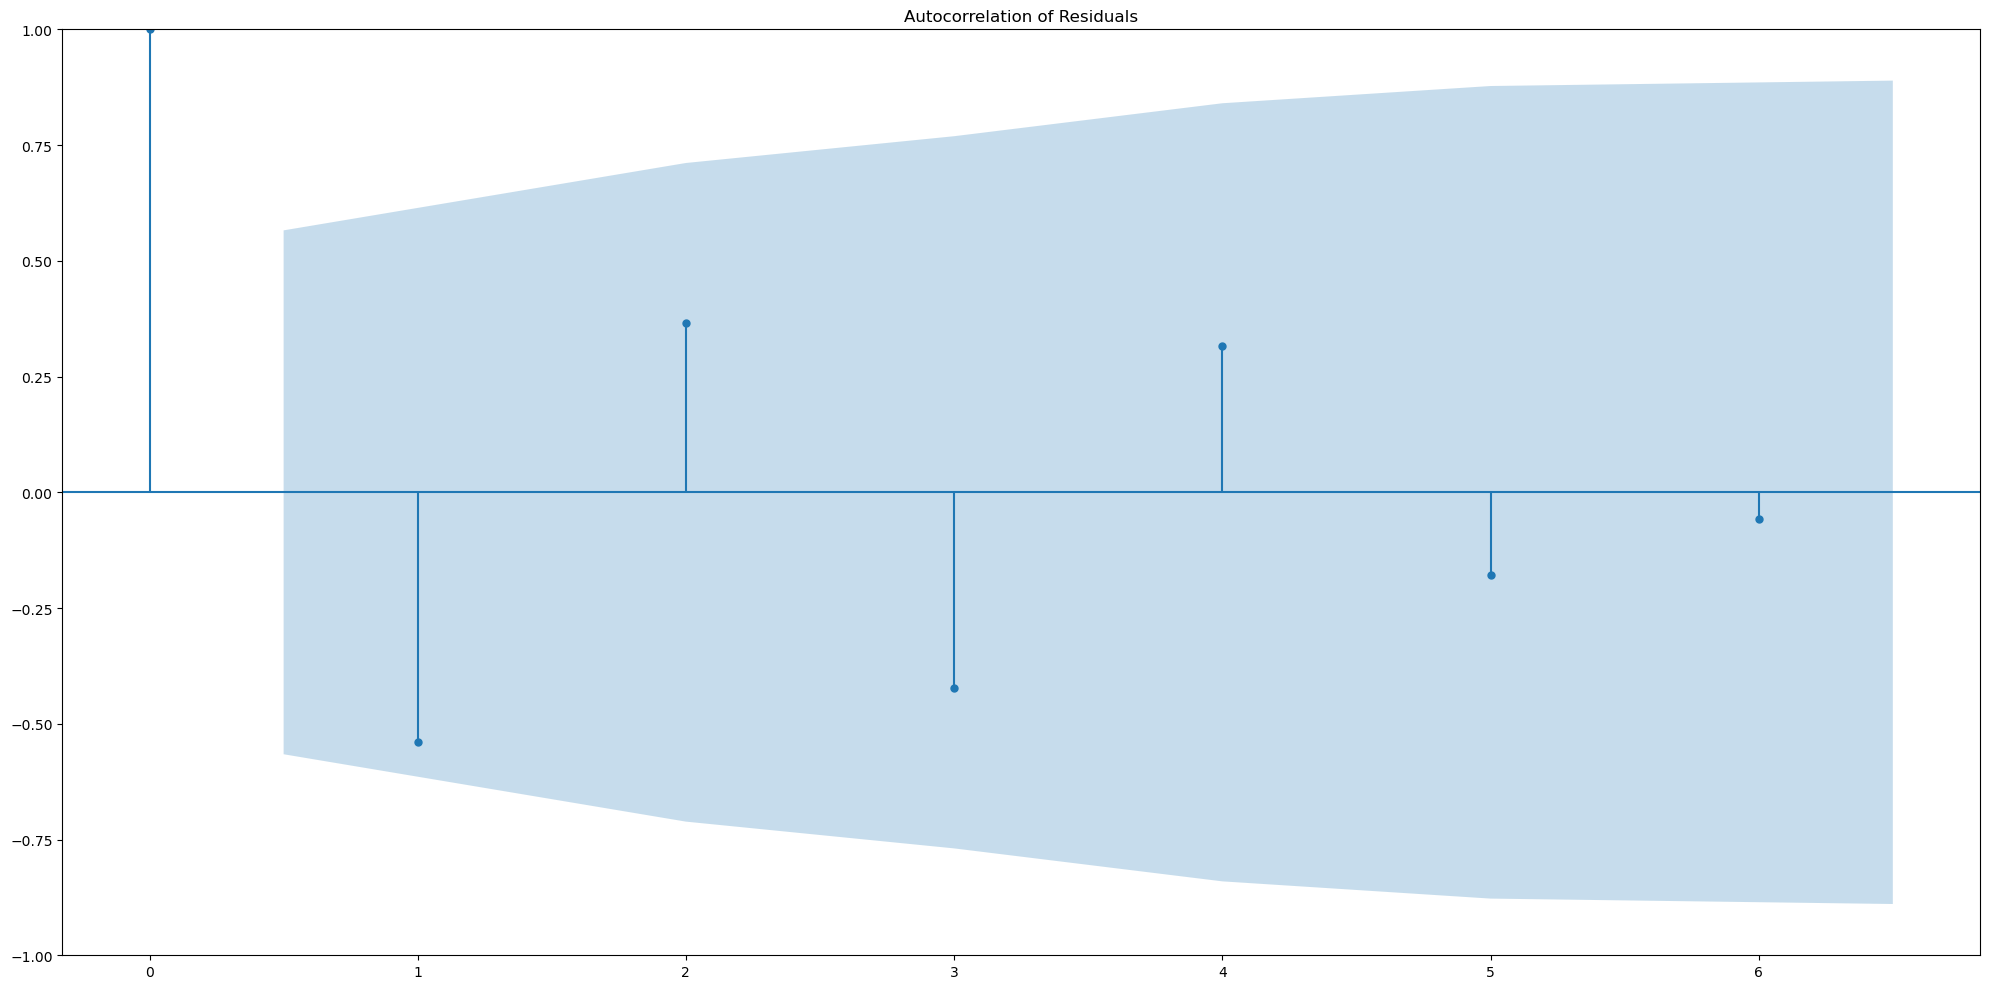

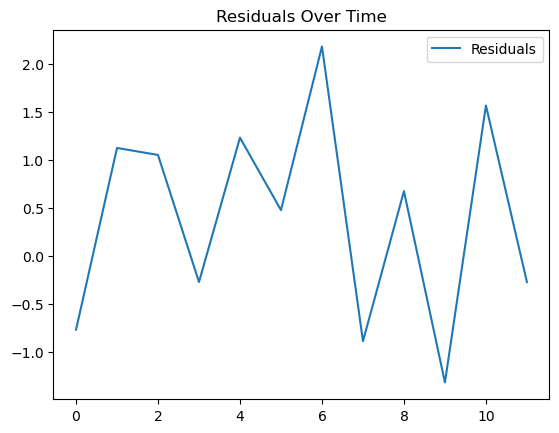

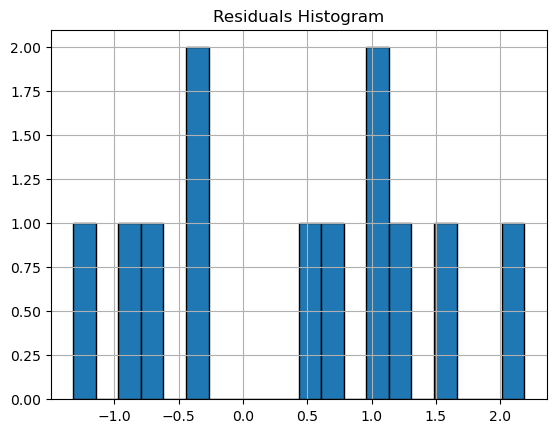

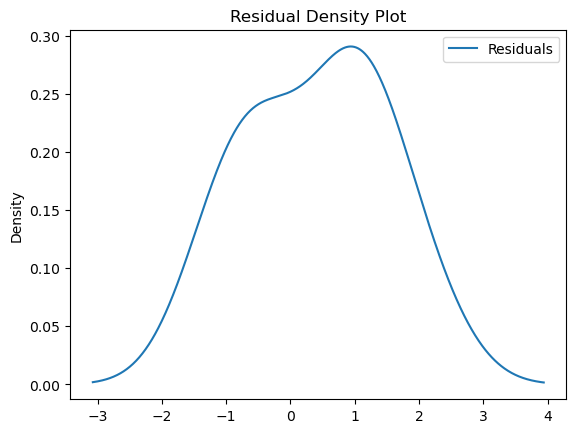

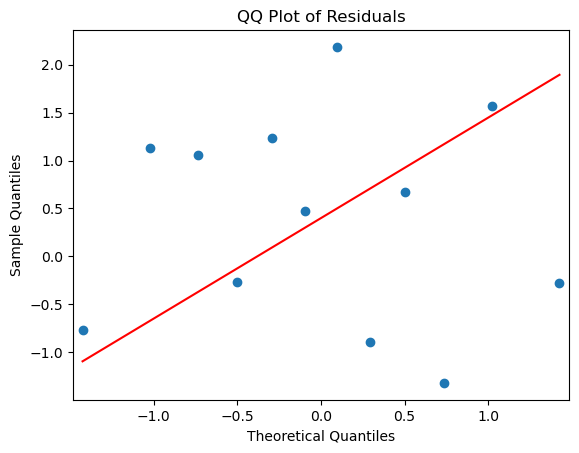

Model      RMSE       MAE       MAPE      MASE      sMAPE
6   Triple Mul  0.935307  0.860341   5.247795  0.326114   5.154510
5   Triple Add  1.122216  0.987610   5.665812  0.374356   5.731680
3   Double Add  2.902854  2.303359  13.254271  0.873094  13.332010
4   Double Mul  2.916421  2.309960  13.994932  0.875596  13.276637
0   Simple 0.2  3.381749  2.649993  14.344632  1.004486  15.533469
2  Simple 0.28  3.432045  2.706090  14.631410  1.025750  15.895866
1   Simple 0.5  3.485984  2.764694  14.931002  1.047964  16.276341

In [ ]:
# Define backtest_2 range
train_end = '2005-06'   # Training data up to June 2005
test_start = '2005-07'  # Test data starts from July 2005
test_end = '2006-06'    # Test data ends in June 2006

# Extract train and test data
train_data = drug_sales_df.loc[:train_end, 'value']
test_data = drug_sales_df.loc[test_start:test_end, 'value']

# Call the function for backtest_2
exponential_smoothing_backtest(train_data, test_data)

### Backtest Period 3 (July 2006 to June 2007)

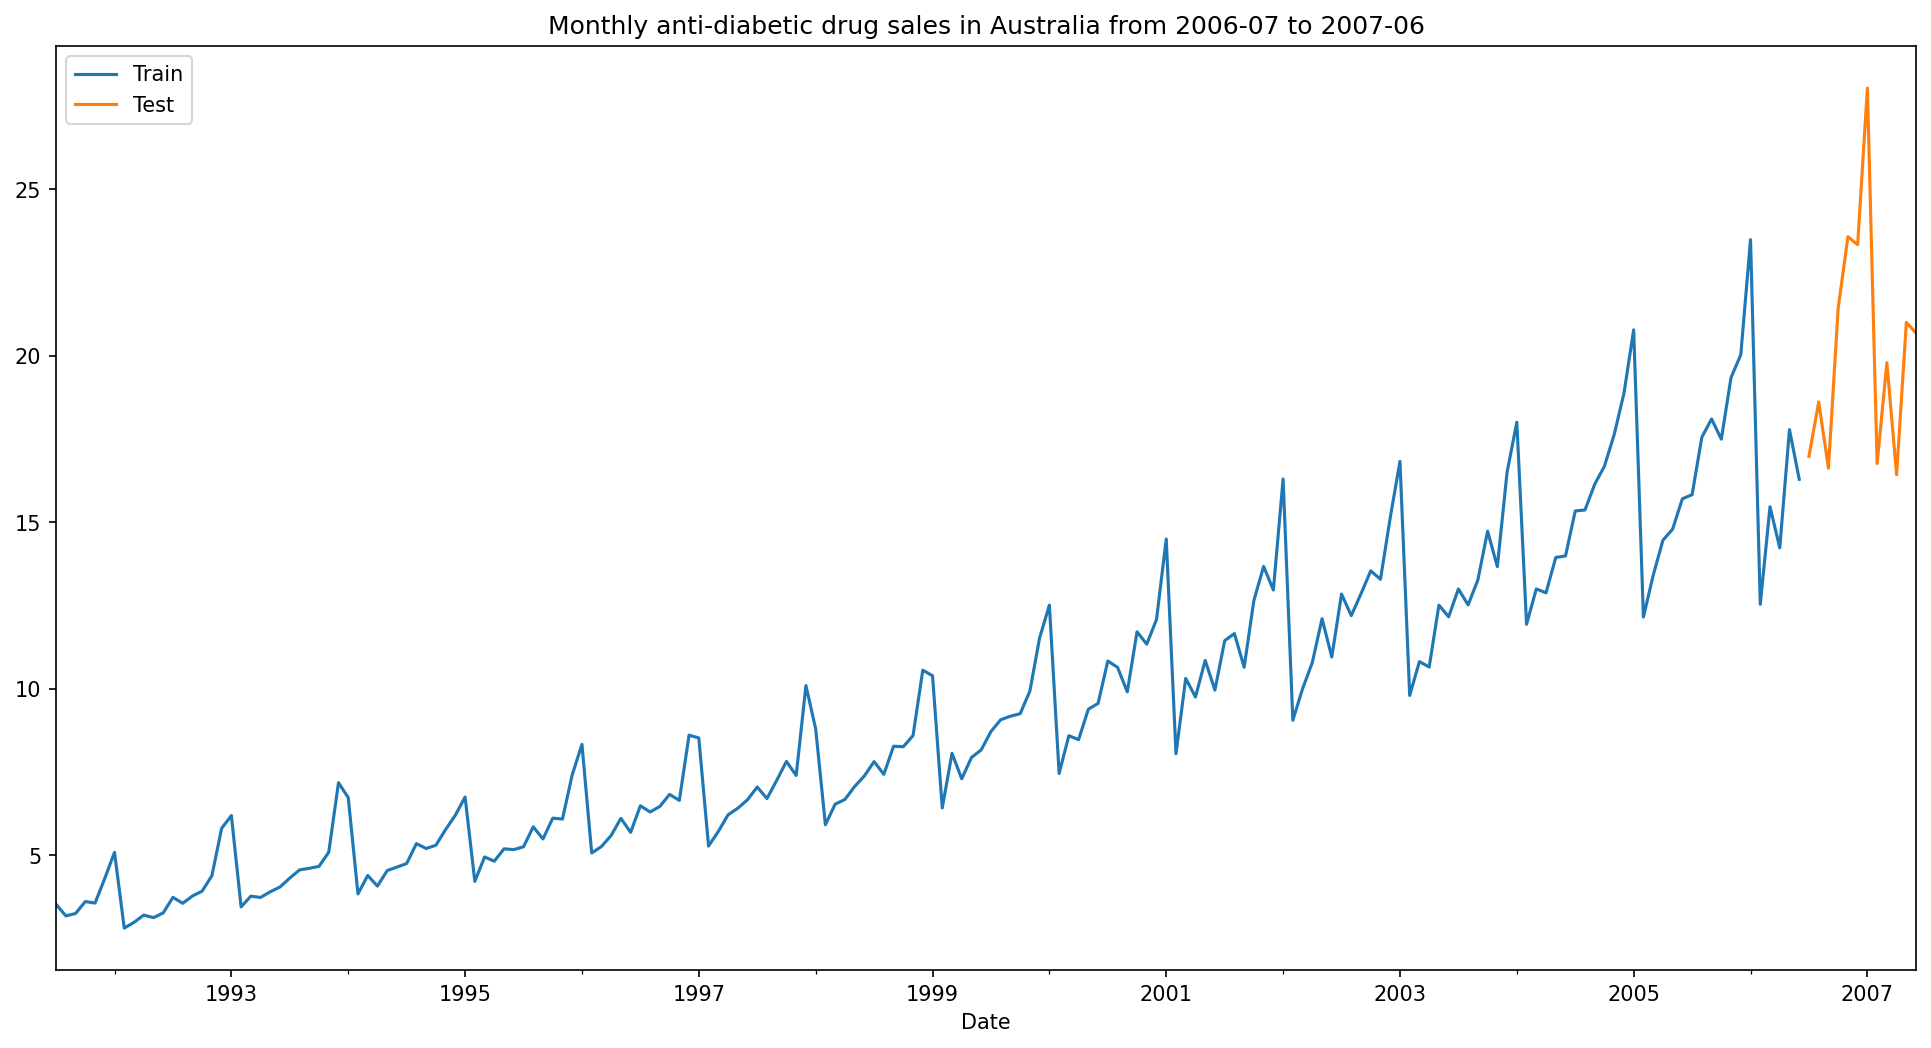

In [41]:
backtest_train_test_graph(drug_sales_df, train_end='2006-06', test_start='2006-07', test_end='2007-06')

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


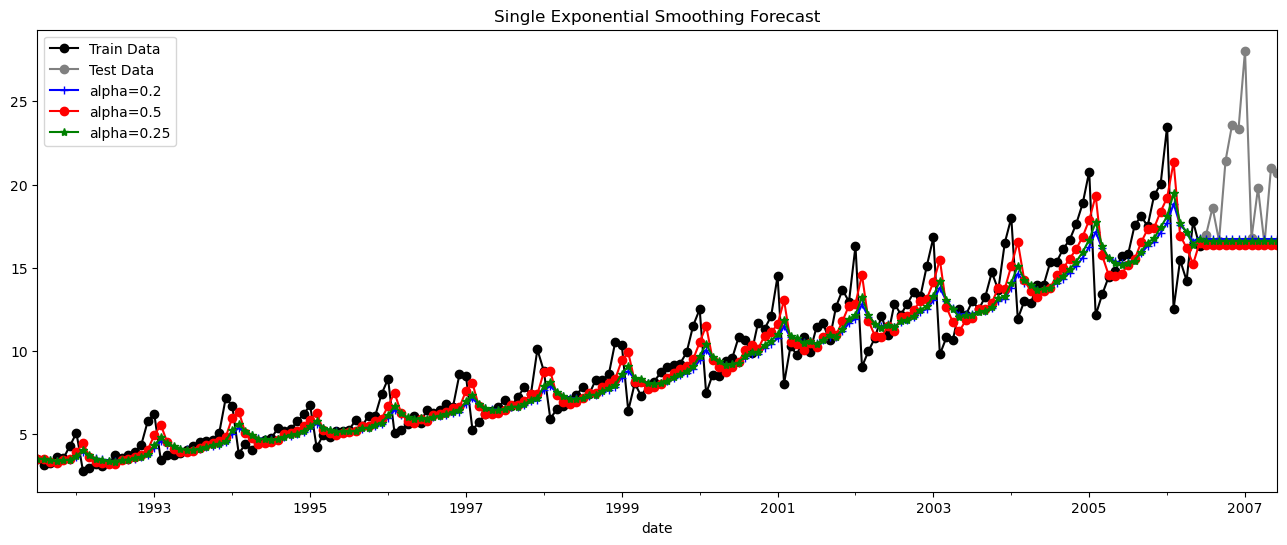

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


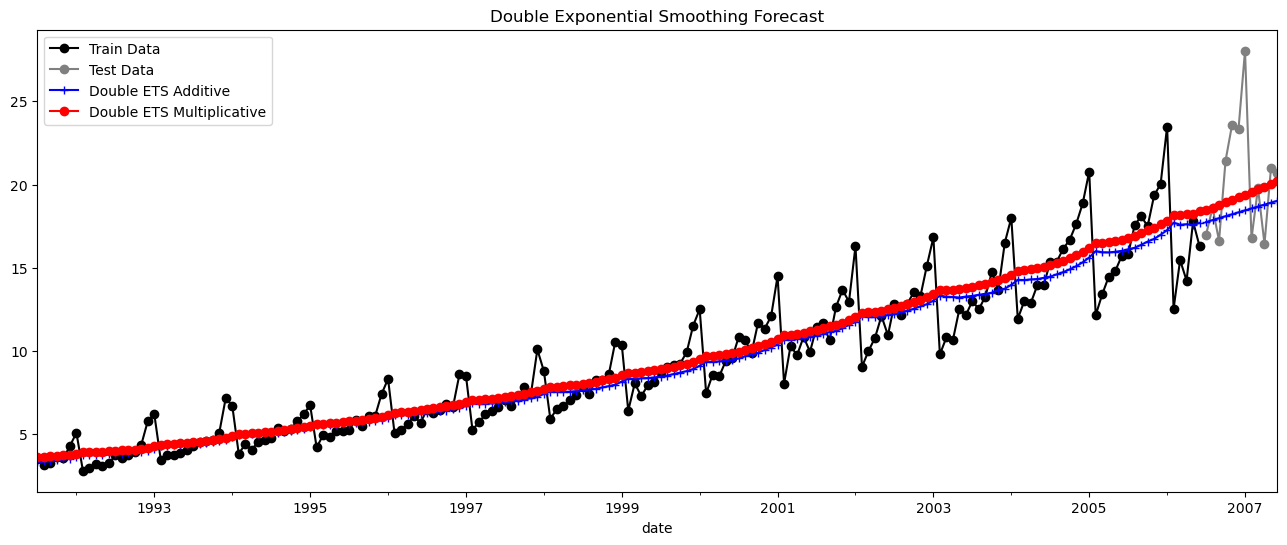

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


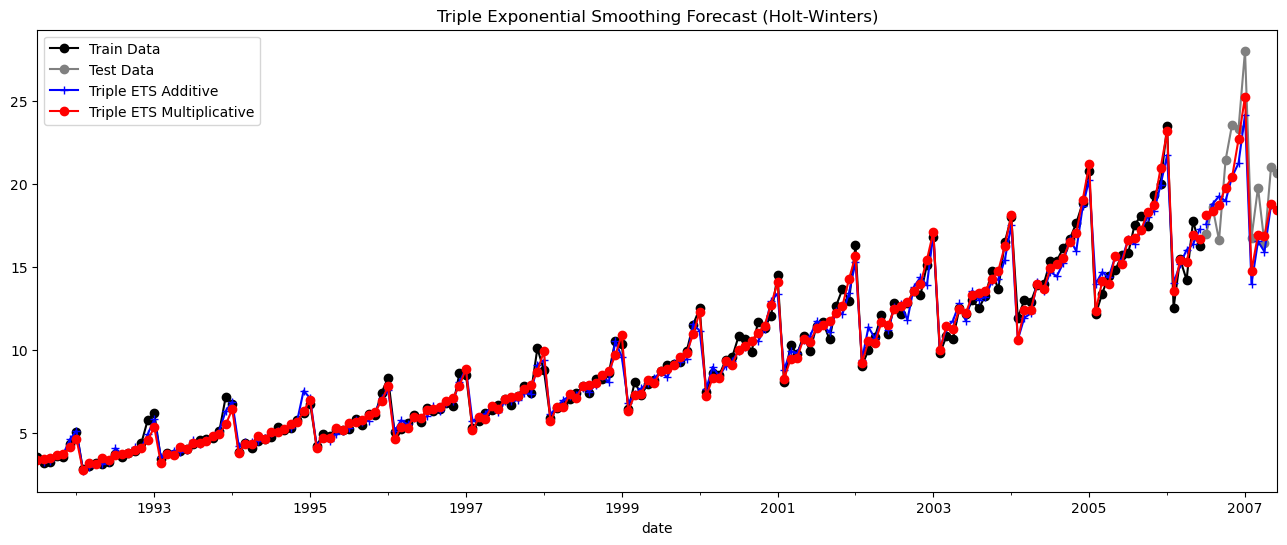

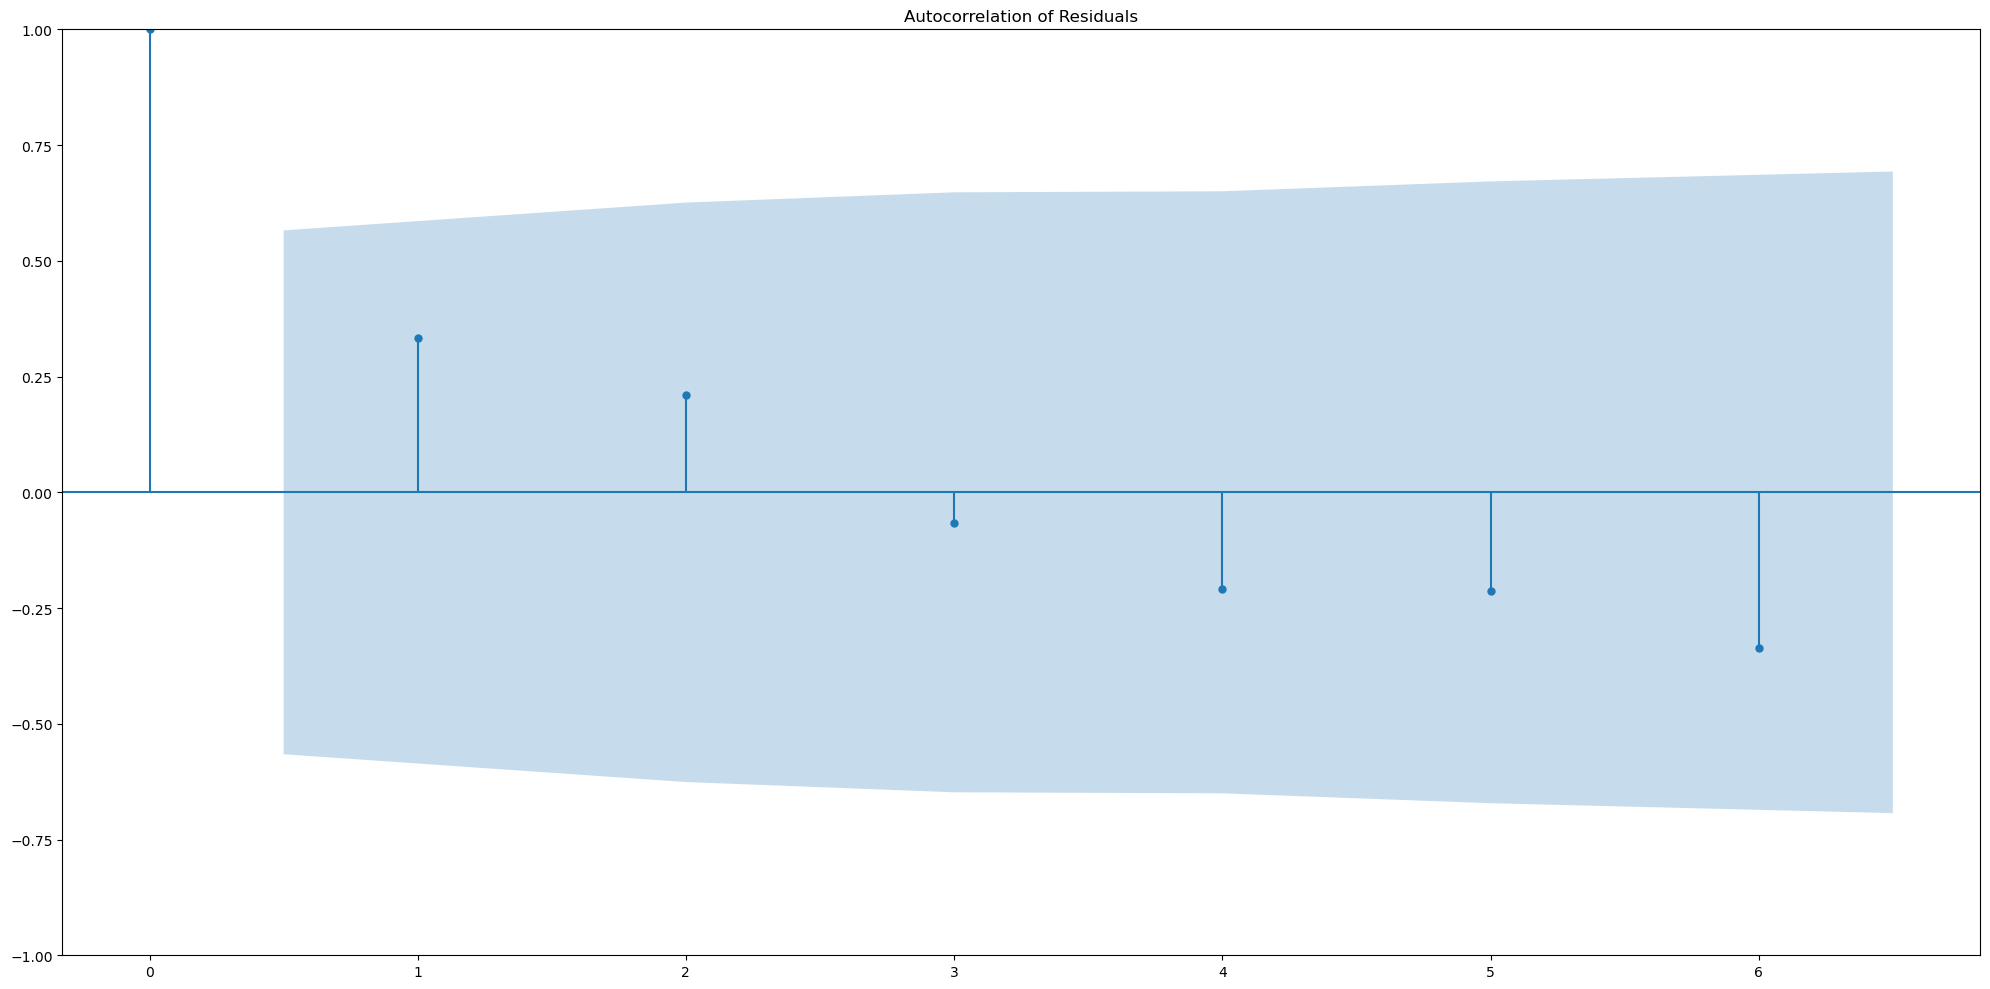

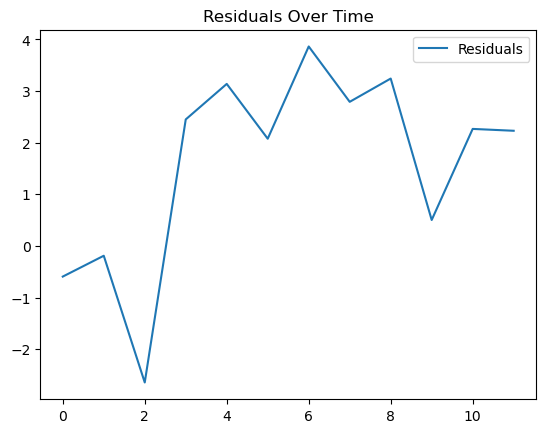

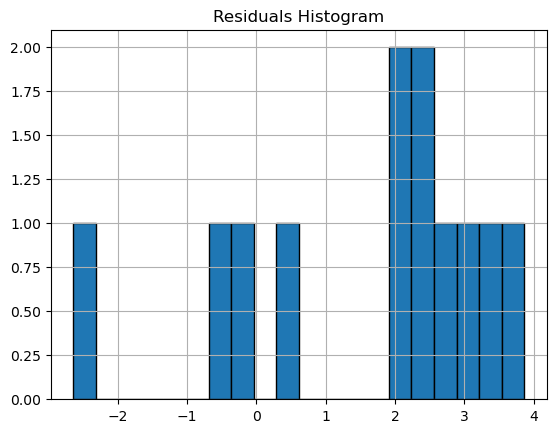

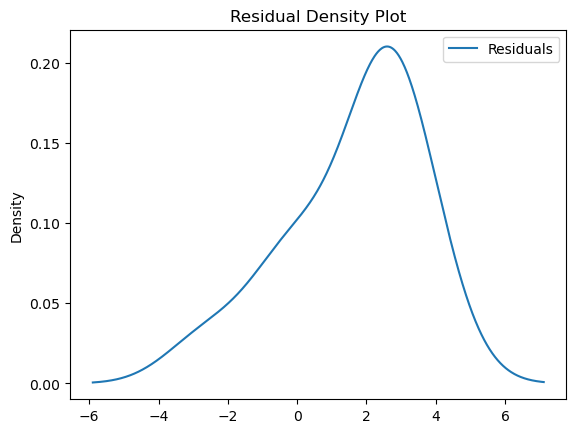

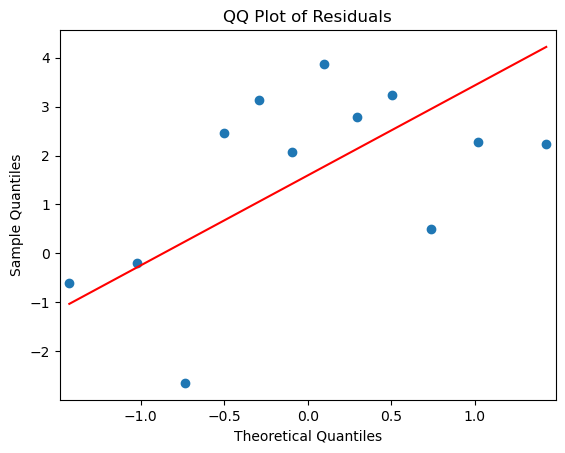

Model      RMSE       MAE       MAPE      MASE      sMAPE
6   Triple Mul  2.018214  1.789434   8.742747  0.516900   9.065220
5   Triple Add  2.434020  2.165085  10.456240  0.625411  10.963436
4   Double Mul  3.484365  2.596247  12.153467  0.749958  12.634370
3   Double Add  3.840684  2.931650  13.278898  0.846843  14.363438
0   Simple 0.2  4.905221  3.620414  15.780736  1.045801  18.180475
2  Simple 0.25  4.966391  3.676336  16.036112  1.061954  18.508660
1   Simple 0.5  5.140457  3.875384  17.007811  1.119452  19.692695

In [45]:
# Define backtest_3 range
train_end = '2006-06'   # Training data up to June 2006
test_start = '2006-07'  # Test data starts from July 2006
test_end = '2007-06'    # Test data ends in June 2007

# Extract train and test data
train_data = drug_sales_df.loc[:train_end, 'value']
test_data = drug_sales_df.loc[test_start:test_end, 'value']

# Call the function for backtest_3
exponential_smoothing_backtest(train_data, test_data)

### Backtest Period 4 (July 2007 to June 2008)

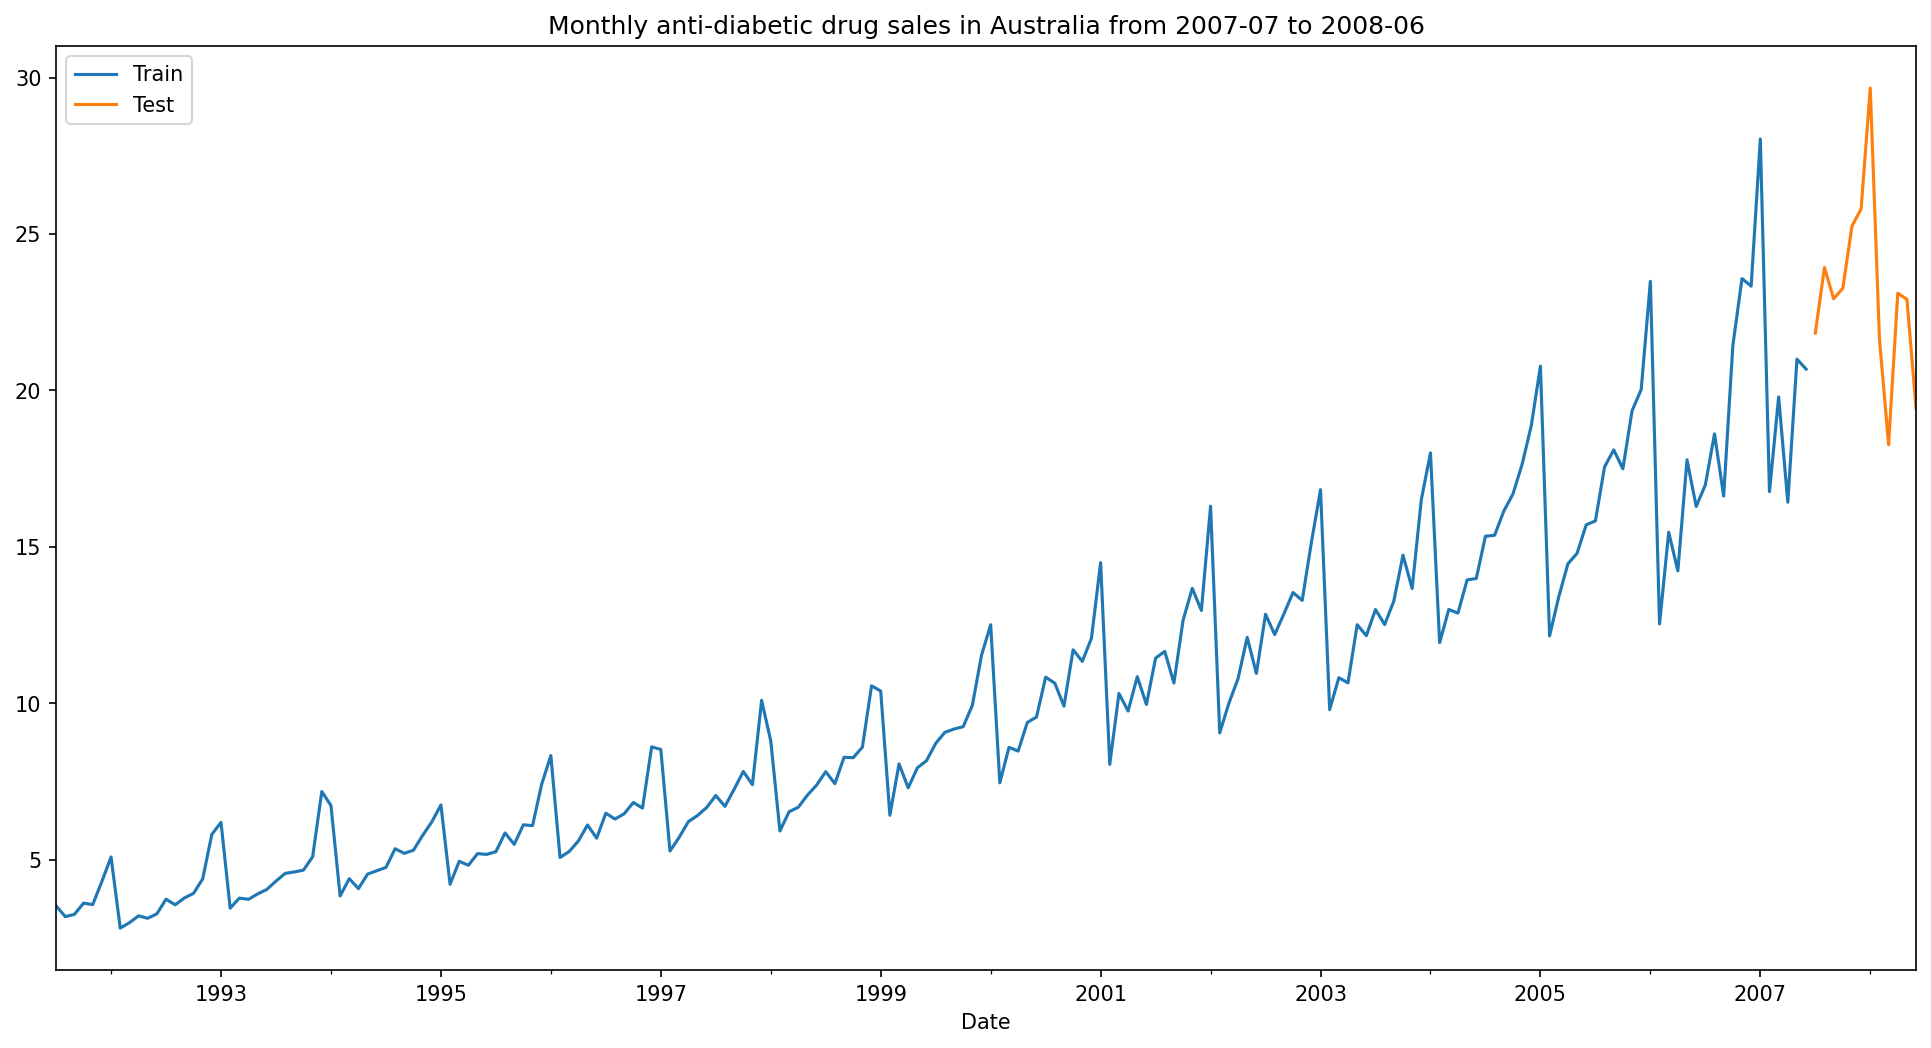

In [44]:
backtest_train_test_graph(drug_sales_df, train_end='2007-06', test_start='2007-07', test_end='2008-06')

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


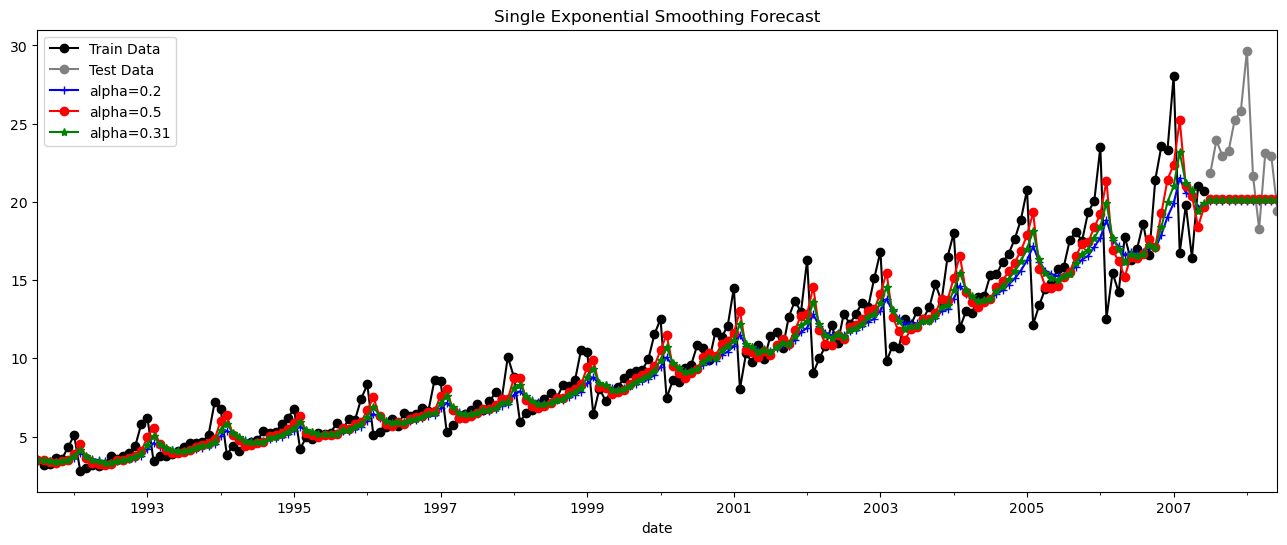

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


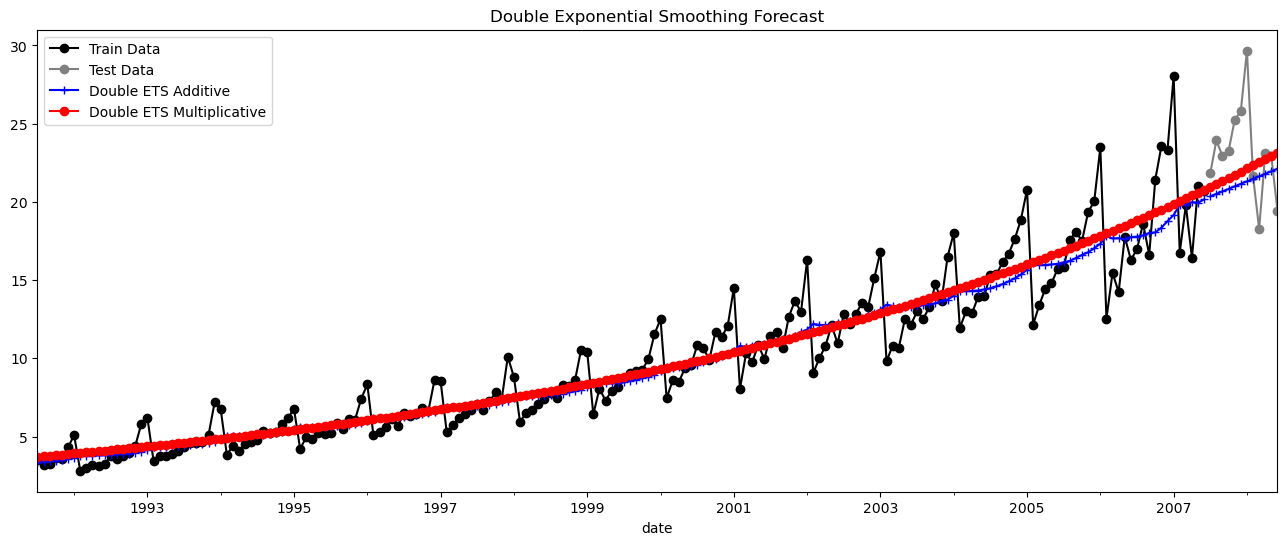

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


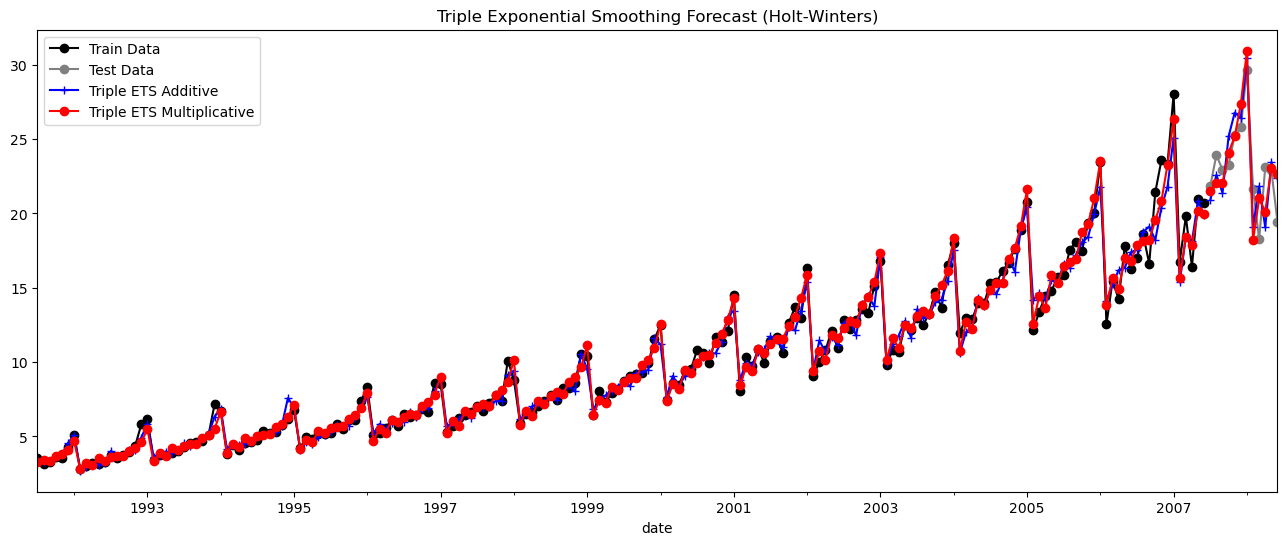

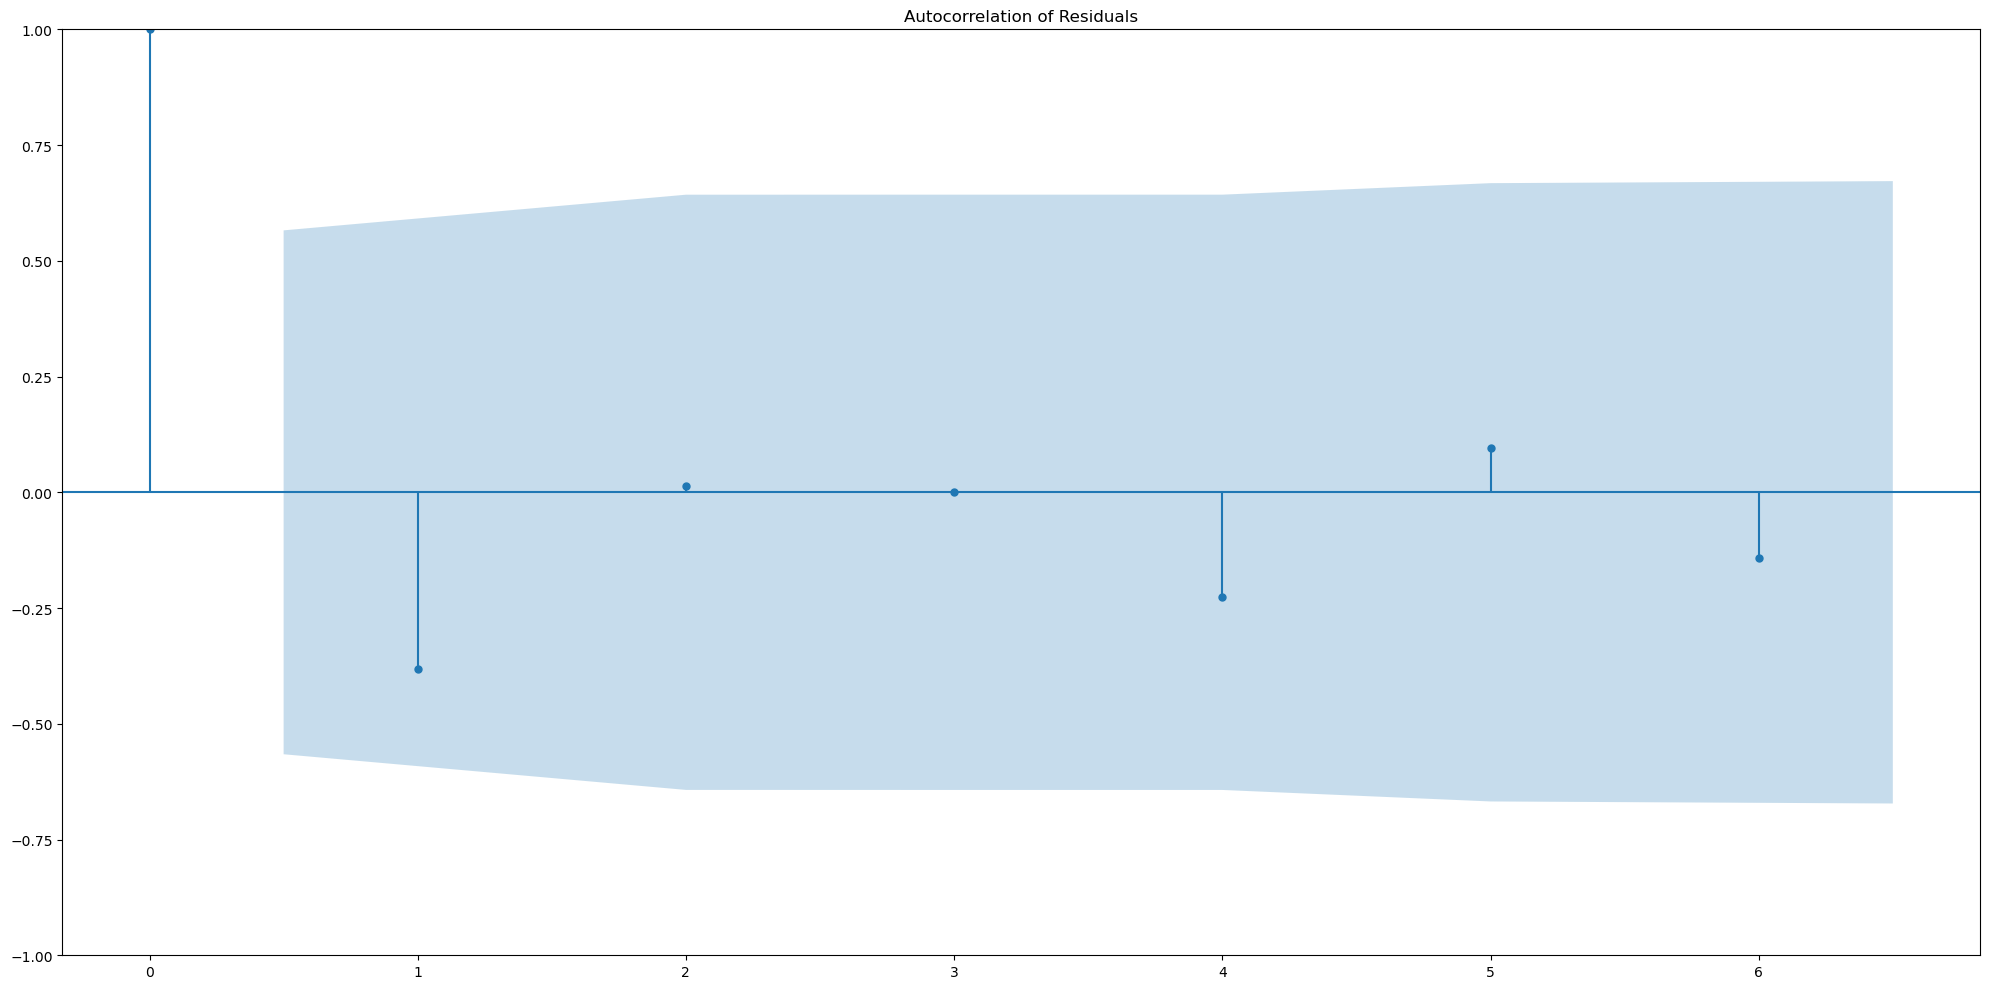

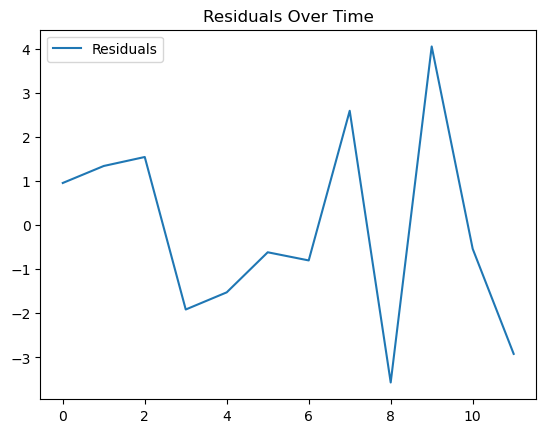

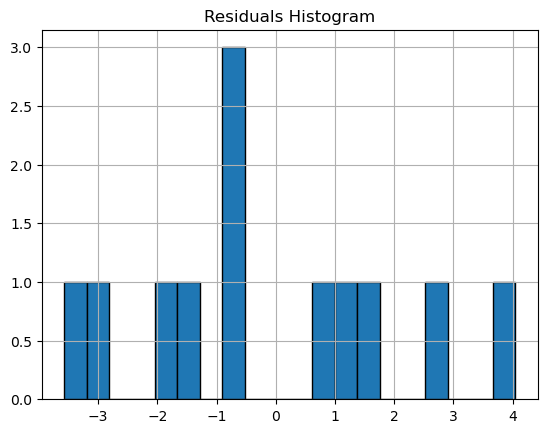

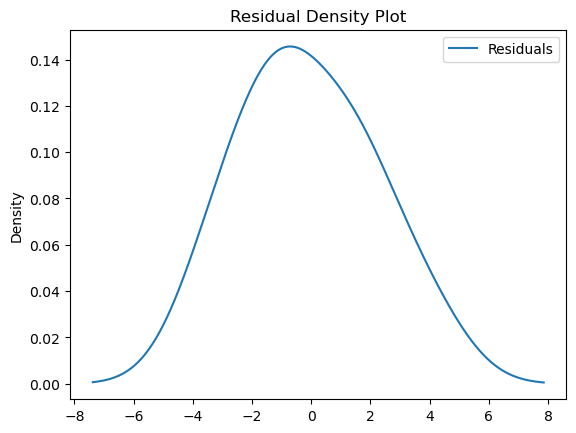

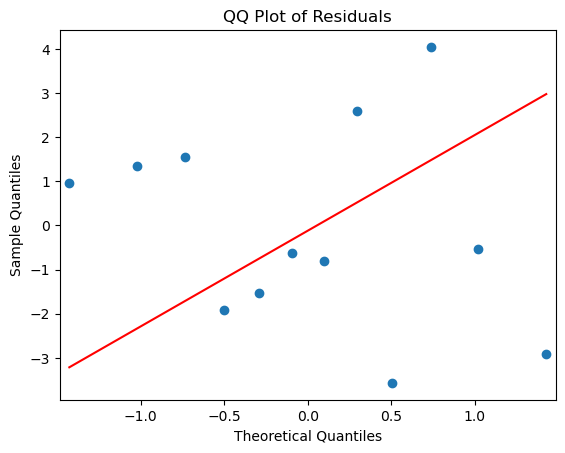

Model      RMSE       MAE       MAPE      MASE      sMAPE
6   Triple Mul  1.998244  1.616817   7.383933  0.597830   7.389564
5   Triple Add  2.174516  1.863363   8.537841  0.688992   8.500086
4   Double Mul  3.298603  2.576589  10.960420  0.952713  11.218424
3   Double Add  3.601454  2.946251  12.280881  1.089398  12.962341
1   Simple 0.5  4.110187  3.426282  13.974314  1.266893  15.264850
2  Simple 0.31  4.139540  3.453203  14.079687  1.276847  15.396820
0   Simple 0.2  4.211767  3.518746  14.336236  1.301082  15.719104

In [46]:
# Define backtest_4 range
train_end = '2007-06'   # Training data up to June 2007
test_start = '2007-07'  # Test data starts from July 2007
test_end = '2008-06'    # Test data ends in June 2008

# Extract train and test data
train_data = drug_sales_df.loc[:train_end, 'value']
test_data = drug_sales_df.loc[test_start:test_end, 'value']

# Call the function for backtest_4
exponential_smoothing_backtest(train_data, test_data)

## ARIMA Models

First, we must check stationarity, difference, filter out validation sample, and select AR and MA terms

In [52]:
def check_stationarity_for_backtests(df, backtest_periods, forecast_months=12):
    """
    Checks stationarity, performs differencing (both regular and seasonal), 
    and performs ADF test for each training period in the backtesting process.
    
    Parameters:
        df (pd.DataFrame): DataFrame with time-based data (indexed by Date).
        backtest_periods (list of tuples): List of tuples defining the test periods (test_start, test_end).
        forecast_months (int): Number of months to forecast for each test period.
        
    Returns:
        None: Prints ADF test results and displays plots
    """
    for i, (test_start, test_end) in enumerate(backtest_periods):
        # The training period ends one month before the test period starts
        train_end = pd.to_datetime(test_start) - pd.DateOffset(months=1)
        train_start = df.index.min()  # Start from the first available date in the data
        
        # Create the training data based on the dynamic length of the training period
        train_data = df.loc[train_start:train_end]

        print(f"\n=== Backtesting Period {i+1} ===")
        print(f"Training Period: {train_start} to {train_end}")
        print(f"Test Period: {test_start} to {test_end}")

        # ADF Test on Training Data
        result = adfuller(train_data.values)
        print(f'ADF Statistic: {result[0]:.6f}')
        print(f'p-value: {result[1]:.6f}')
        print('Critical Values:')
        for key, value in result[4].items():
            print(f'\t{key}: {value:.3f}')

        # Regular Differencing
        first_diff = train_data.diff().dropna()

        # Plot differenced series
        plt.figure(figsize=(10, 4))
        plt.plot(first_diff, color='blue')
        plt.title(f"First Differencing - Backtesting Period {i+1}")
        plt.show()

        # Autocorrelation Plot of Differenced Data
        fig = plot_acf(first_diff, lags=50)
        fig.set_size_inches((10, 5))
        fig.tight_layout()
        plt.title(f"Autocorrelation of Differenced Data - Backtesting Period {i+1}")
        plt.show()

        # Seasonal Differencing (12 months)
        seasonal_diff_df = first_diff.diff(12).dropna()

        # Plot seasonal differenced series
        plt.figure(figsize=(10, 4))
        plt.plot(seasonal_diff_df, color='blue')
        plt.title(f"Seasonal Differencing (12 months) - Backtesting Period {i+1}")
        plt.show()

        # Autocorrelation Plot of Seasonal Differenced Data
        fig = plot_acf(seasonal_diff_df, lags=100)
        fig.set_size_inches((10, 5))
        fig.tight_layout()
        plt.title(f"Autocorrelation of Seasonal Differenced Data - Backtesting Period {i+1}")
        plt.show()

        #plot PACF of the differenced time series.
        plot_pacf(seasonal_diff_df)
        plt.show()

        # ADF Test on Seasonal Differenced Data
        X = seasonal_diff_df.values
        result = adfuller(X)
        print(f'Seasonal ADF Statistic: {result[0]:.6f}')
        print(f'Seasonal p-value: {result[1]:.6f}')
        print('Critical Values:')
        for key, value in result[4].items():
            print(f'\t{key}: {value:.3f}')



=== Backtesting Period 1 ===
Training Period: 1991-07-01 00:00:00 to 2004-06-01 00:00:00
Test Period: 2004-07-01 to 2005-06-30
ADF Statistic: 2.044324
p-value: 0.998728
Critical Values:
	1%: -3.478
	5%: -2.882
	10%: -2.578


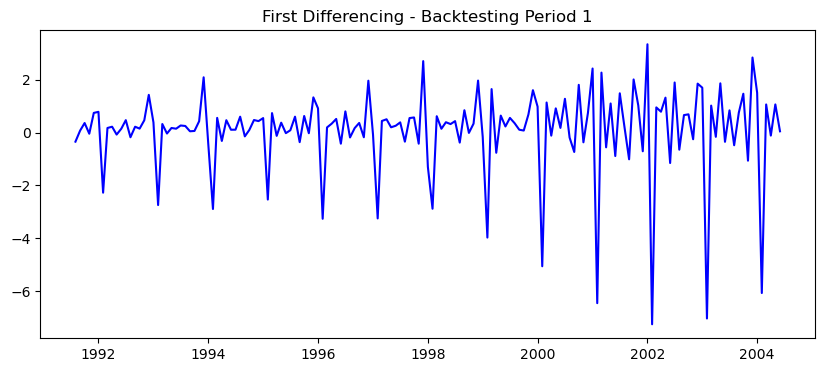

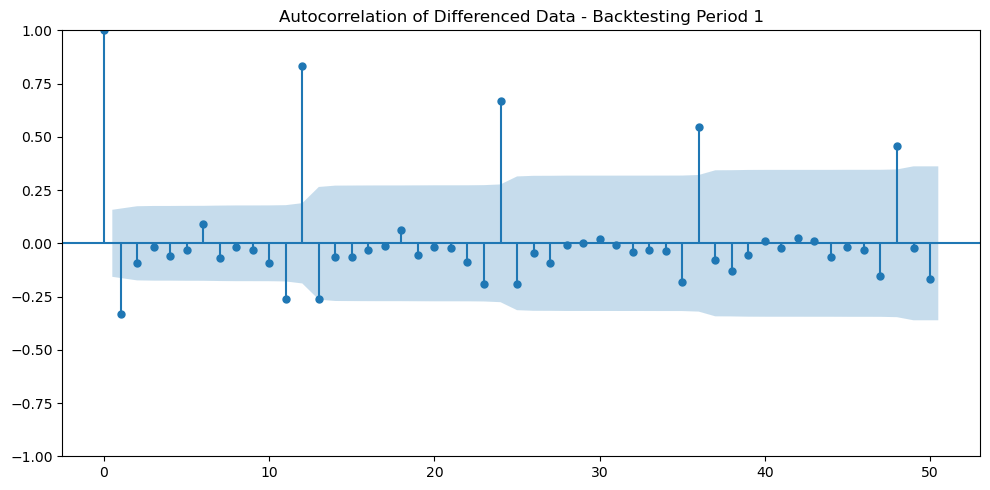

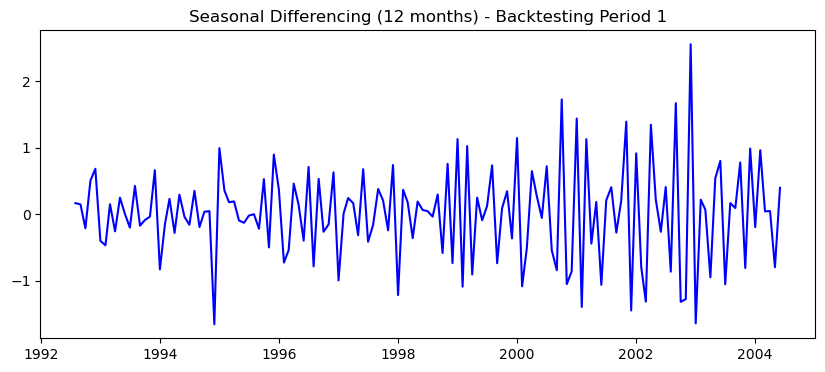

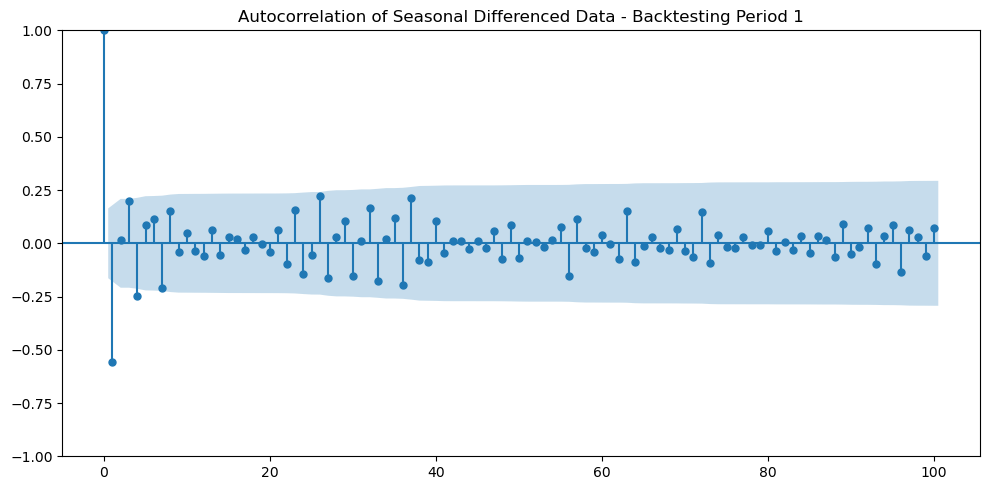

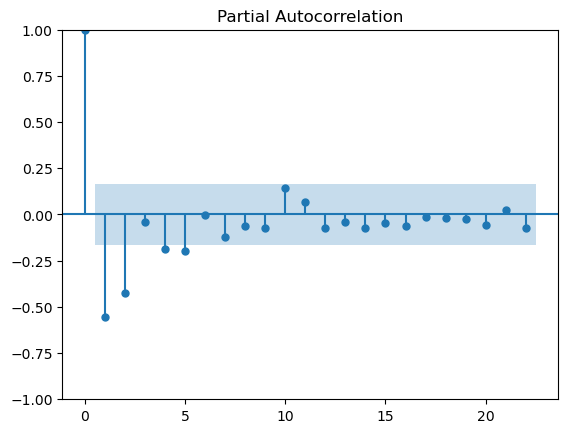

Seasonal ADF Statistic: -8.922385
Seasonal p-value: 0.000000
Critical Values:
	1%: -3.479
	5%: -2.883
	10%: -2.578

=== Backtesting Period 2 ===
Training Period: 1991-07-01 00:00:00 to 2005-06-01 00:00:00
Test Period: 2005-07-01 to 2006-06-30
ADF Statistic: 2.218998
p-value: 0.998898
Critical Values:
	1%: -3.474
	5%: -2.881
	10%: -2.577


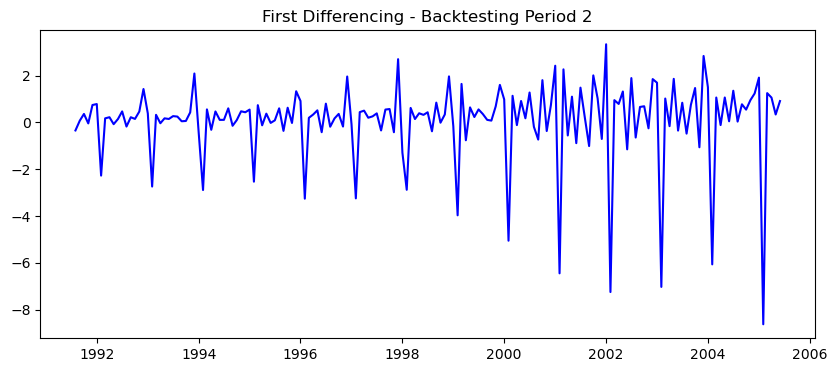

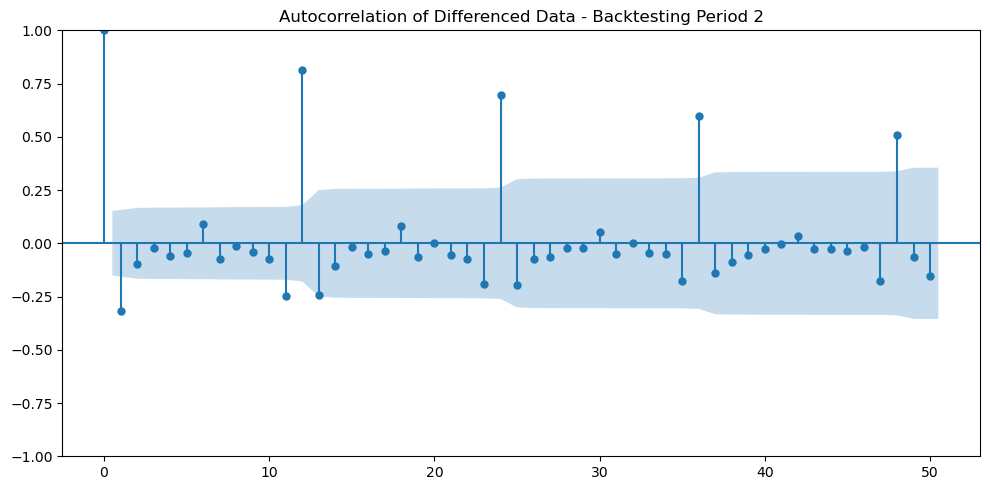

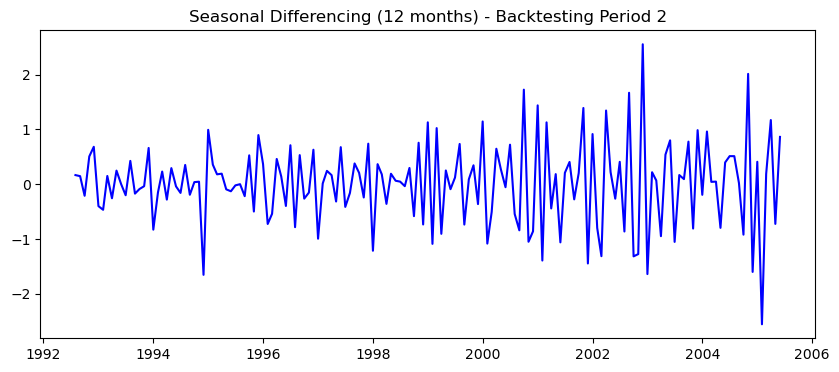

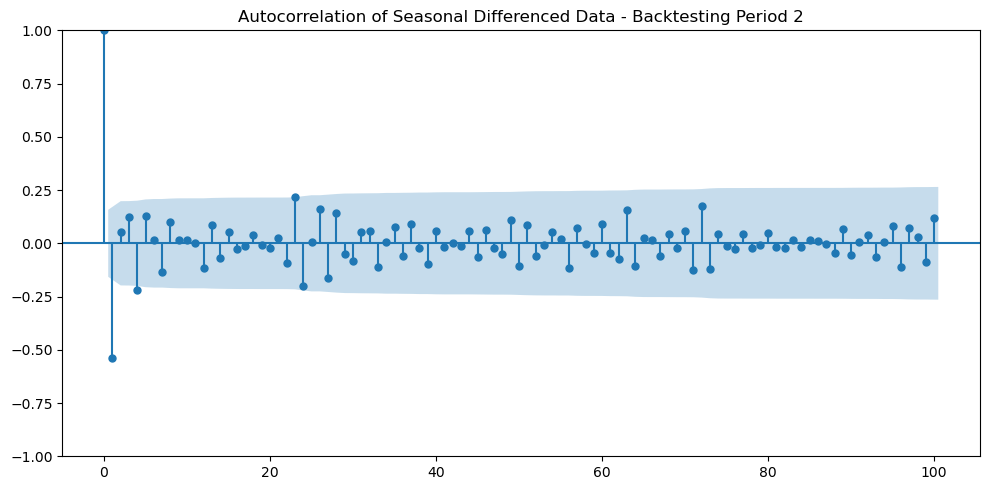

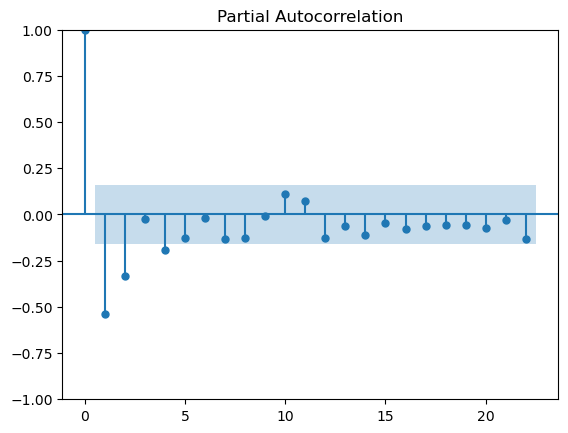

Seasonal ADF Statistic: -8.452470
Seasonal p-value: 0.000000
Critical Values:
	1%: -3.475
	5%: -2.881
	10%: -2.577

=== Backtesting Period 3 ===
Training Period: 1991-07-01 00:00:00 to 2006-06-01 00:00:00
Test Period: 2006-07-01 to 2007-06-30
ADF Statistic: 2.478849
p-value: 0.999043
Critical Values:
	1%: -3.471
	5%: -2.879
	10%: -2.576


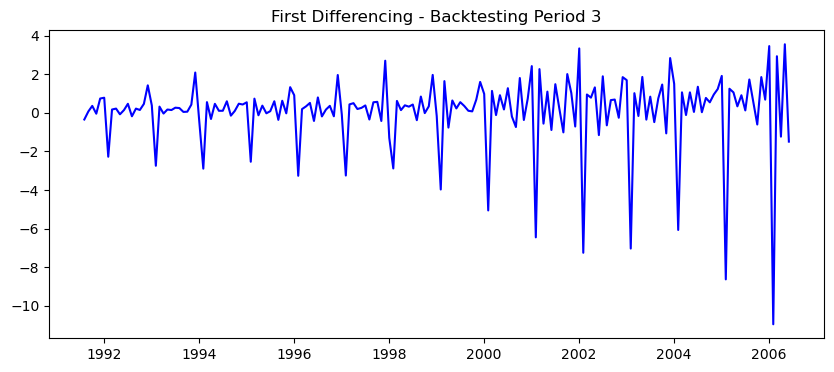

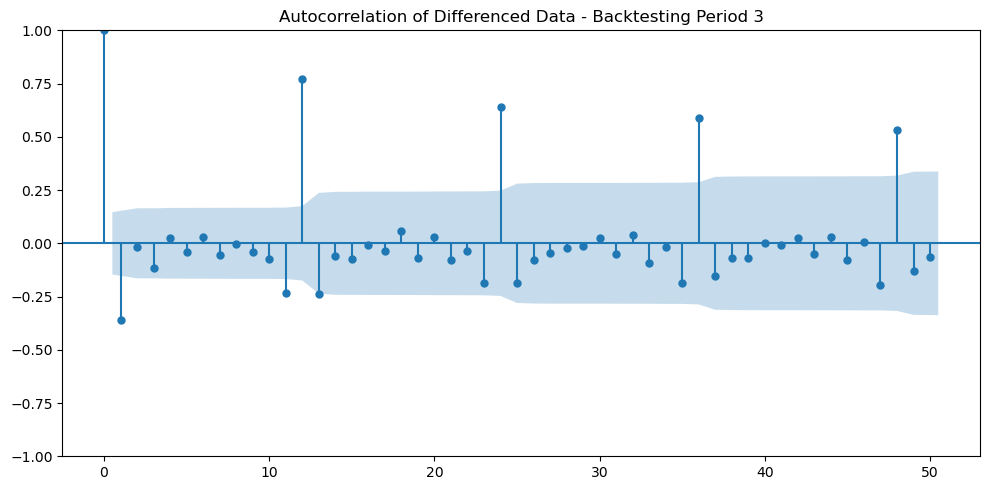

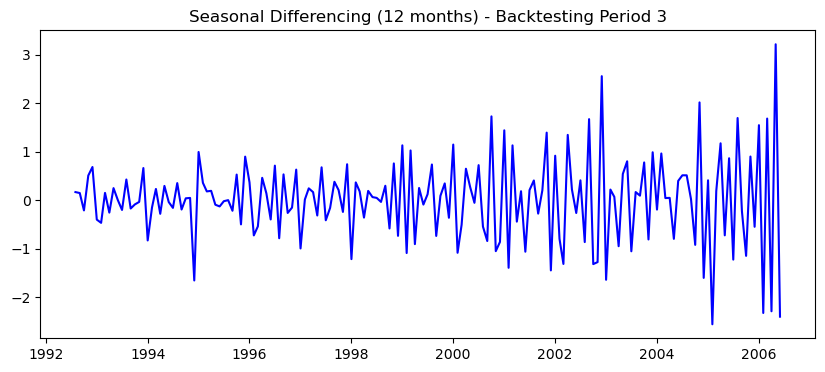

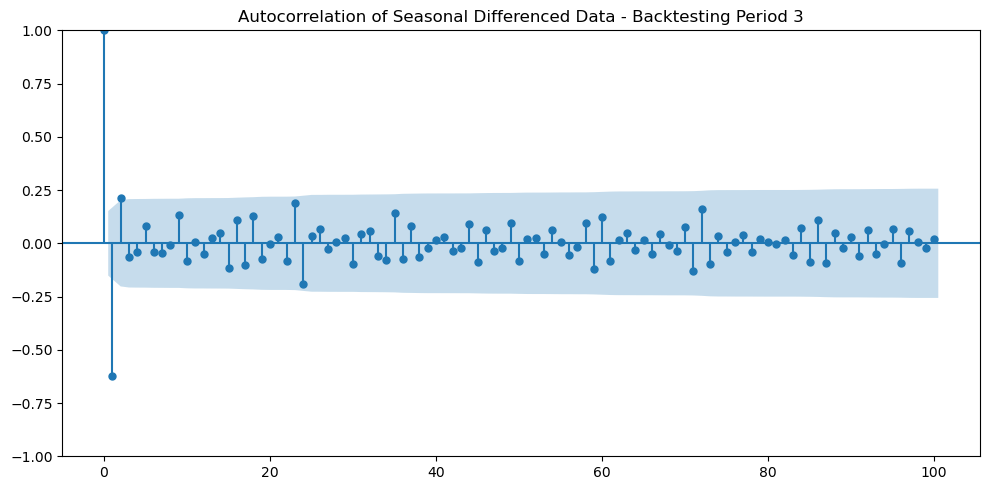

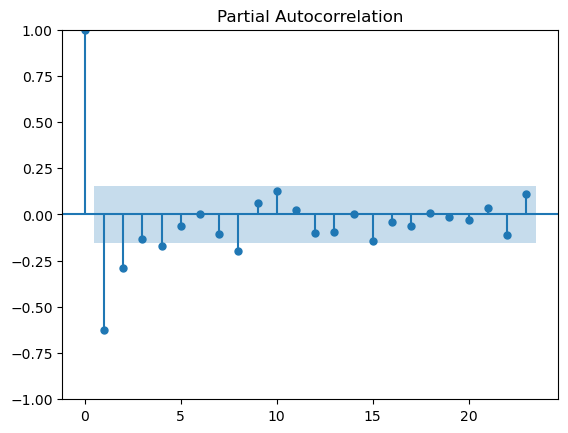

Seasonal ADF Statistic: -7.358254
Seasonal p-value: 0.000000
Critical Values:
	1%: -3.472
	5%: -2.880
	10%: -2.577

=== Backtesting Period 4 ===
Training Period: 1991-07-01 00:00:00 to 2007-06-01 00:00:00
Test Period: 2007-07-01 to 2008-06-30
ADF Statistic: 3.060197
p-value: 1.000000
Critical Values:
	1%: -3.468
	5%: -2.878
	10%: -2.576


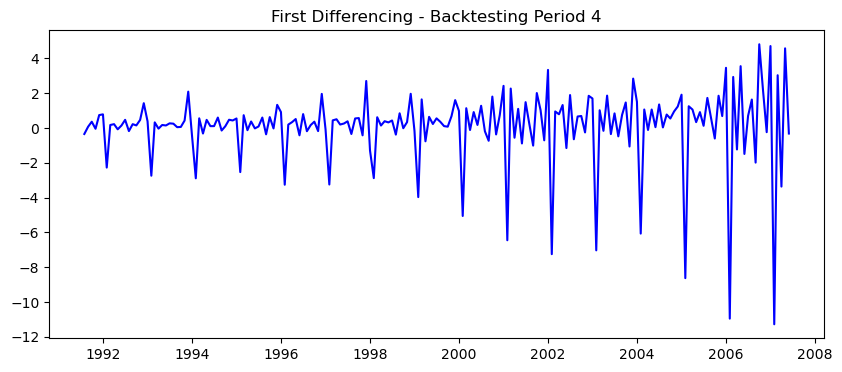

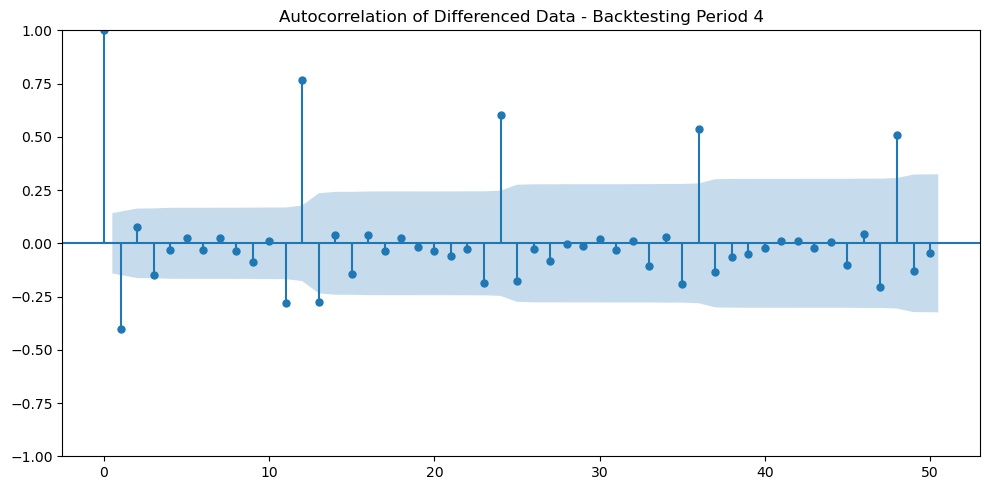

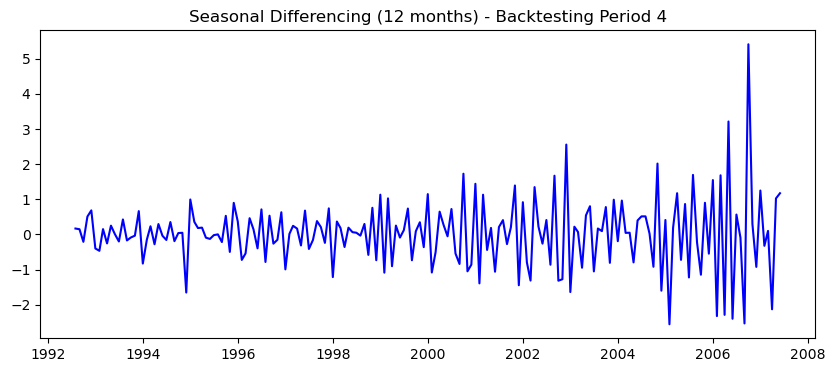

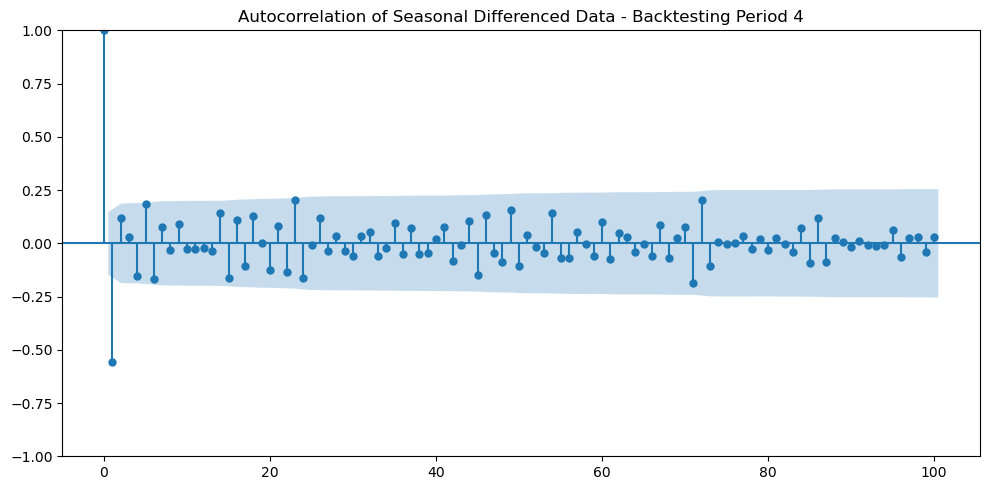

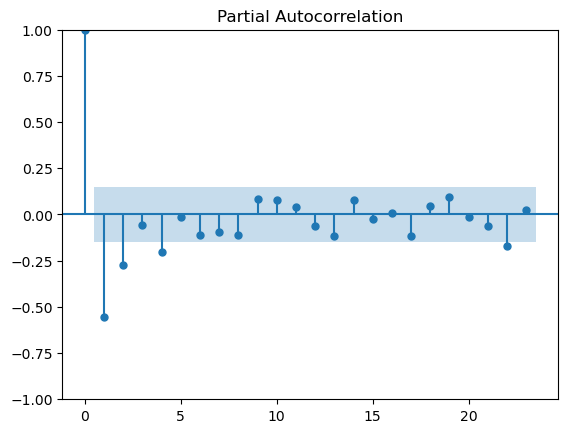

Seasonal ADF Statistic: -9.986393
Seasonal p-value: 0.000000
Critical Values:
	1%: -3.468
	5%: -2.878
	10%: -2.576


In [53]:
backtest_periods = [
    ("2004-07-01", "2005-06-30"),
    ("2005-07-01", "2006-06-30"),
    ("2006-07-01", "2007-06-30"),
    ("2007-07-01", "2008-06-30")
]

check_stationarity_for_backtests(drug_sales_df, backtest_periods)

### Building and Validating the ARIMA Models

In [70]:
# Define the metrics_cal function with an additional backtest_period argument
def metrics_cal(actuals, predictions, model, backtest_period):
    mse = mean_squared_error(actuals, predictions)
    rmse = sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100

    df = pd.DataFrame({'Model': [model],
                       'RMSE': [rmse],
                       'MAE': [mae],
                       'MAPE': [mape],
                       'Backtest_Period': [backtest_period]})  # Added backtest_period

    return df

def backtest_auto_arima(df, backtest_periods, forecast_months=12):
    """
    Perform Auto ARIMA (both non-seasonal and seasonal) for each backtesting period.
    
    Parameters:
        df (pd.DataFrame): DataFrame with time-based data (indexed by Date).
        backtest_periods (list of tuples): List of tuples defining the test periods (test_start, test_end).
        forecast_months (int): Number of months to forecast for each test period.
        
    Returns:
        metrics_dataframe (pd.DataFrame): Dataframe with performance metrics (RMSE, MAE, MAPE).
    """
    metrics_dataframe = pd.DataFrame(columns=['Model', 'RMSE', 'MAE', 'MAPE', 'Backtest_Period'])

    for i, (test_start, test_end) in enumerate(backtest_periods):
        # Training data ends one month before the test period starts
        train_end = pd.to_datetime(test_start) - pd.DateOffset(months=1)
        train_start = df.index.min()  # Start from the first available date in the data
        
        # Create the training data for the given period
        train_data = df.loc[train_start:train_end]
        test_data = df.loc[test_start:test_end]

        print(f"\n=== Backtesting Period {i+1} ===")
        print(f"Training Period: {train_start} to {train_end}")
        print(f"Test Period: {test_start} to {test_end}")

        # Non-Seasonal Auto ARIMA
        non_seasonal_auto_model = pm.auto_arima(train_data, start_p=0, start_q=0,
                                                test='adf', max_p=3, max_q=3,
                                                m=12, d=None, seasonal=False,
                                                trace=True, error_action='ignore',
                                                suppress_warnings=True, stepwise=True)

        print("\nNon-Seasonal Model Summary:")
        print(non_seasonal_auto_model.summary())

        # Forecast
        fc_auto_nonseasonal, confint = non_seasonal_auto_model.predict(n_periods=forecast_months, return_conf_int=True)
        fc_series_auto_nonseasonal = pd.Series(fc_auto_nonseasonal, index=test_data.index)
        lower_series = pd.Series(confint[:, 0], index=test_data.index)
        upper_series = pd.Series(confint[:, 1], index=test_data.index)

        # Plot Non-Seasonal Forecast
        plt.figure(figsize=(12, 5), dpi=100)
        plt.plot(train_data, label='train')
        plt.plot(test_data, label='test')
        plt.plot(fc_series_auto_nonseasonal, color='darkgreen', label='forecast')
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
        plt.title(f"Non-Seasonal Forecast for Backtest Period {i+1}")
        plt.legend(loc='upper left', fontsize=8)
        plt.show()

        # Calculate Metrics for Non-Seasonal ARIMA
        metrics_df_nonseasonal = metrics_cal(test_data.values.flatten(),
                                             fc_series_auto_nonseasonal.values.flatten(),
                                             'Auto ARIMA Non Seasonal', f'{test_start} to {test_end}')
        metrics_dataframe = pd.concat([metrics_dataframe, metrics_df_nonseasonal], ignore_index=True)

        # Seasonal Auto ARIMA
        seasonal_auto_model = pm.auto_arima(train_data, start_p=1, start_q=1, 
                                            test='adf', max_p=3, max_q=3, m=12,
                                            start_P=0, seasonal=True, d=None,
                                            D=1, trace=True, error_action='ignore',
                                            suppress_warnings=True, stepwise=True)

        print("\nSeasonal Model Summary:")
        print(seasonal_auto_model.summary())

        # Forecast
        fc_auto_seasonal, confint = seasonal_auto_model.predict(n_periods=forecast_months, return_conf_int=True)
        fc_series_auto_seasonal = pd.Series(fc_auto_seasonal, index=test_data.index)
        lower_series = pd.Series(confint[:, 0], index=test_data.index)
        upper_series = pd.Series(confint[:, 1], index=test_data.index)

        # Plot Seasonal Forecast
        plt.figure(figsize=(12, 5), dpi=100)
        plt.plot(train_data, label='train')
        plt.plot(test_data, label='test')
        plt.plot(fc_series_auto_seasonal, color='darkblue', label='forecast')
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
        plt.title(f"Seasonal Forecast for Backtest Period {i+1}")
        plt.legend(loc='upper left', fontsize=8)
        plt.show()

        # Calculate Metrics for Seasonal ARIMA
        metrics_df_seasonal = metrics_cal(test_data.values.flatten(),
                                          fc_series_auto_seasonal.values.flatten(),
                                          'Auto ARIMA Seasonal', f'{test_start} to {test_end}')
        metrics_dataframe = pd.concat([metrics_dataframe, metrics_df_seasonal], ignore_index=True)

        # Average Predictions (combining non-seasonal and seasonal forecasts)
        avg_pred = (fc_series_auto_nonseasonal.values.flatten() +
                    fc_series_auto_seasonal.values.flatten()) / 2
        metrics_df_avg = metrics_cal(test_data.values.flatten(),
                                     avg_pred,
                                     'Average', f'{test_start} to {test_end}')
        metrics_dataframe = pd.concat([metrics_dataframe, metrics_df_avg], ignore_index=True)

        # Create a DataFrame with all predictions along with the test data
        test_pred_df = test_data.copy()
        test_pred_df['auto_nonseasonal_pred'] = fc_series_auto_nonseasonal.values.flatten()
        test_pred_df['auto_seasonal_pred'] = fc_series_auto_seasonal.values.flatten()
        test_pred_df['avg_pred'] = avg_pred

        print(f"Test Predictions for Backtest Period {i+1}:")
        print(test_pred_df)

    return metrics_dataframe




=== Backtesting Period 1 ===
Training Period: 1991-07-01 00:00:00 to 2004-06-01 00:00:00
Test Period: 2004-07 to 2005-06
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1123.692, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=598.075, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=961.453, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=565.571, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=558.166, Time=0.06 sec


/opt/anaconda3/lib/python3.12/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


 ARIMA(3,0,1)(0,0,0)[0]             : AIC=560.084, Time=0.10 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=566.735, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=558.602, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=578.450, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=558.613, Time=0.09 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0]          
Total fit time: 0.746 seconds

Non-Seasonal Model Summary:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  156
Model:               SARIMAX(2, 0, 1)   Log Likelihood                -275.083
Date:                Mon, 03 Feb 2025   AIC                            558.166
Time:                        02:24:53   BIC                            570.365
Sample:                    07-01-1991   HQIC                           563.120
                         - 06-01-2

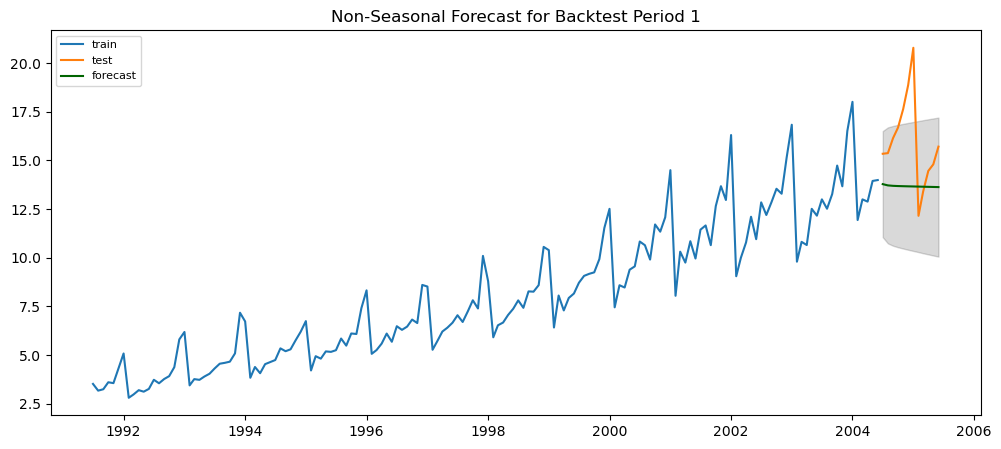

/var/folders/hj/_jmscth928bcdm9fr013zqzr0000gn/T/ipykernel_86687/2387809593.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_dataframe = pd.concat([metrics_dataframe, metrics_df_nonseasonal], ignore_index=True)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=226.709, Time=0.16 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=310.796, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=260.993, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=227.309, Time=0.11 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=229.668, Time=0.05 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=225.508, Time=0.55 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=228.659, Time=0.17 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=225.817, Time=0.77 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=226.347, Time=0.99 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=224.365, Time=0.68 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=224.161, Time=0.51 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=225.964, Time=1.49 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=225.121, Time=0.54 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=306.412, Time=0.77 sec
 ARIMA(0,1,2)(0,1,2)[12]         

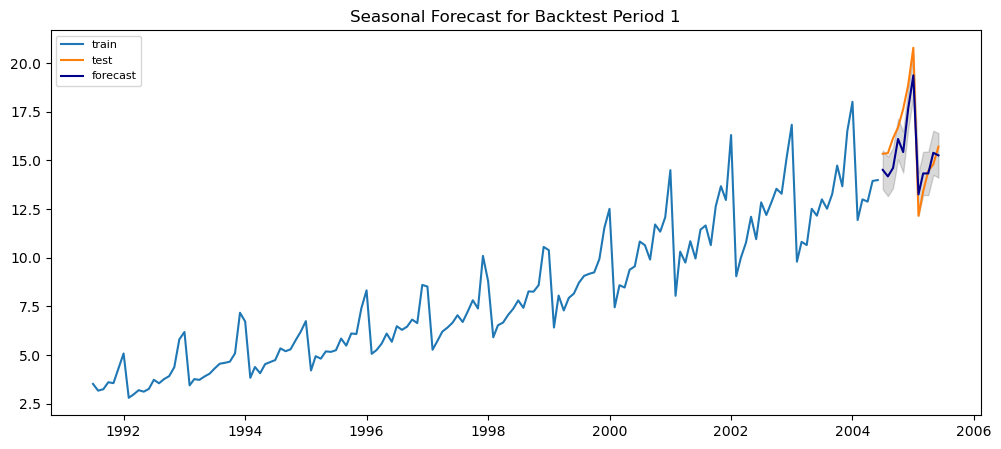

Test Predictions for Backtest Period 1:
                value  auto_nonseasonal_pred  auto_seasonal_pred   avg_pred
date                                                                       
2004-07-01  15.339097              13.779698           14.511723  14.145711
2004-08-01  15.370764              13.715521           14.178493  13.947007
2004-09-01  16.142005              13.692685           14.609965  14.151325
2004-10-01  16.685754              13.681590           16.099150  14.890370
2004-11-01  17.636728              13.673829           15.424339  14.549084
2004-12-01  18.869325              13.667019           17.652307  15.659663
2005-01-01  20.778723              13.660479           19.364360  16.512420
2005-02-01  12.154552              13.654020           13.253868  13.453944
2005-03-01  13.402392              13.647584           14.329013  13.988299
2005-04-01  14.459239              13.641158           14.331788  13.986473
2005-05-01  14.795102              13.634737    

/opt/anaconda3/lib/python3.12/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=624.012, Time=0.09 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=625.917, Time=0.08 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=634.244, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=624.754, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=643.701, Time=0.16 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=624.552, Time=0.08 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0]          
Total fit time: 0.799 seconds

Non-Seasonal Model Summary:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  168
Model:               SARIMAX(2, 0, 1)   Log Likelihood                -308.006
Date:                Mon, 03 Feb 2025   AIC                            624.012
Time:                        02:25:06   BIC                            636.508
Sample:                    07-01-1991   HQIC    

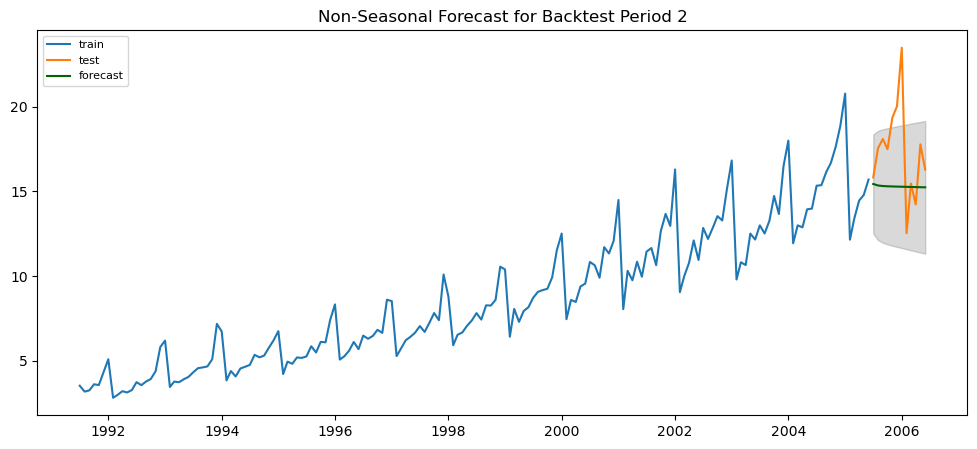

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=277.978, Time=0.99 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=328.707, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=307.343, Time=0.32 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=317.216, Time=0.20 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=495.695, Time=0.02 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=284.962, Time=0.15 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.07 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=278.584, Time=1.54 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=281.078, Time=0.96 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=7.82 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=306.862, Time=0.70 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=277.468, Time=2.99 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=284.849, Time=0.31 sec
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=3.42 sec
 ARIMA(2,0,1)(0,1,2)[12] intercept   : AIC=27

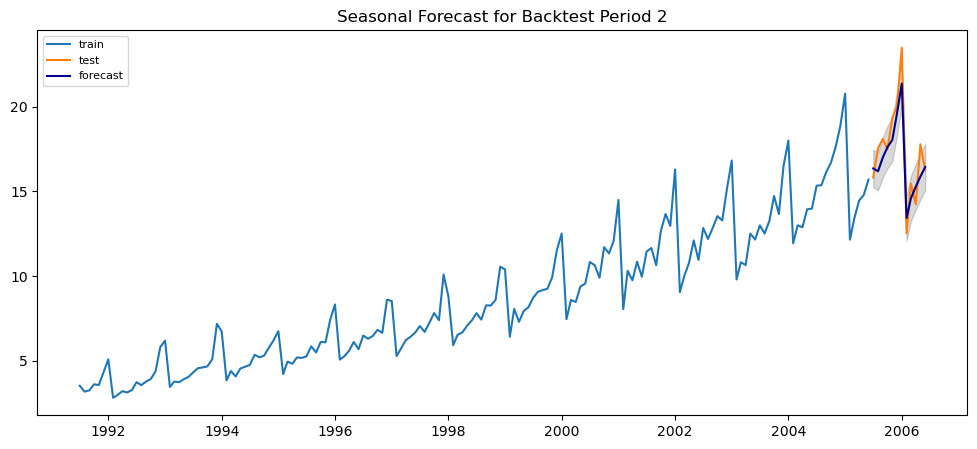

Test Predictions for Backtest Period 2:
                value  auto_nonseasonal_pred  auto_seasonal_pred   avg_pred
date                                                                       
2005-07-01  15.829550              15.441084           16.360382  15.900733
2005-08-01  17.554701              15.353400           16.193577  15.773489
2005-09-01  18.100864              15.320947           17.011254  16.166100
2005-10-01  17.496668              15.305781           17.621825  16.463803
2005-11-01  19.347265              15.296027           18.045498  16.670763
2005-12-01  20.031291              15.287969           19.594596  17.441282
2006-01-01  23.486694              15.280444           21.373333  18.326889
2006-02-01  12.536987              15.273089           13.432175  14.352632
2006-03-01  15.467018              15.265789           14.597304  14.931546
2006-04-01  14.233539              15.258508           15.278109  15.268309
2006-05-01  17.783058              15.251237    

/opt/anaconda3/lib/python3.12/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=711.946, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=703.384, Time=0.09 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=705.294, Time=0.11 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=710.434, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=705.089, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=695.975, Time=0.15 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=695.560, Time=0.28 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=695.085, Time=0.45 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=704.127, Time=0.14 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=696.191, Time=0.25 sec

Best model:  ARIMA(2,0,3)(0,0,0)[0]          
Total fit time: 1.971 seconds

Non-Seasonal Model Summary:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  180
Model:               SARI

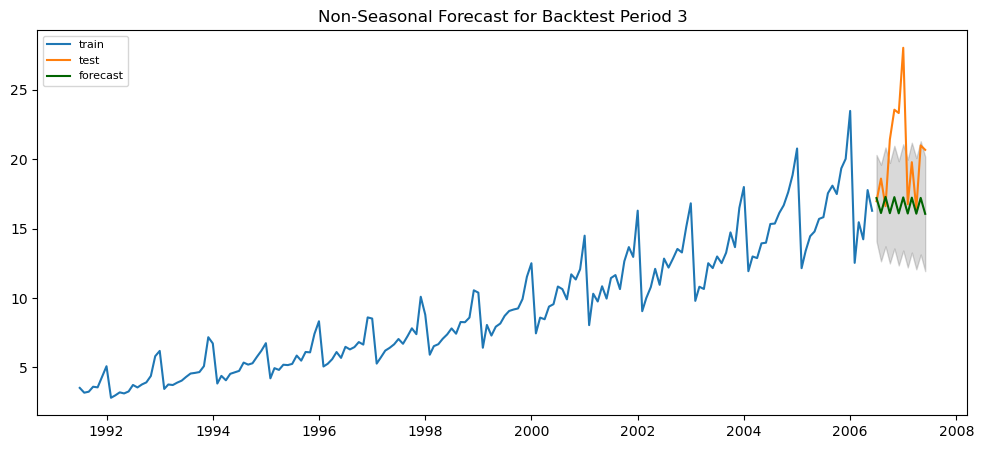

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=331.086, Time=1.65 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=369.596, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=362.402, Time=0.83 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=367.046, Time=0.88 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=546.314, Time=0.03 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=332.975, Time=0.26 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=10.85 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=329.553, Time=10.71 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=335.077, Time=3.36 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=368.302, Time=0.52 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=362.333, Time=0.94 sec
 ARIMA(2,0,1)(0,1,2)[12] intercept   : AIC=323.157, Time=1.54 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=323.874, Time=0.62 sec
 ARIMA(2,0,1)(1,1,2)[12] intercept   : AIC=325.450, Time=4.13 sec
 ARIMA(2,0,1)(1,1,1)[12] intercept 

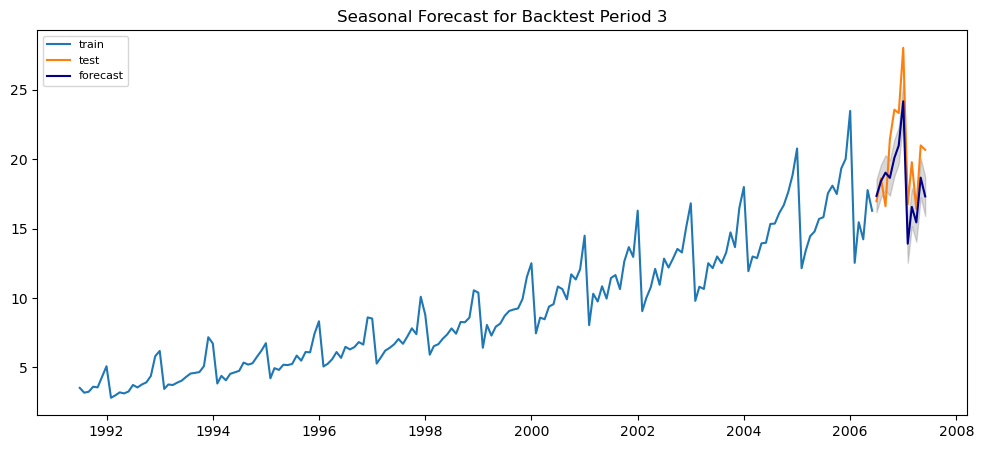

Test Predictions for Backtest Period 3:
                value  auto_nonseasonal_pred  auto_seasonal_pred   avg_pred
date                                                                       
2006-07-01  16.980282              17.206652           17.361109  17.283881
2006-08-01  18.612189              16.129658           18.431777  17.280718
2006-09-01  16.623343              17.292447           19.036023  18.164235
2006-10-01  21.430241              16.117671           18.661527  17.389599
2006-11-01  23.575517              17.274343           20.104632  18.689487
2006-12-01  23.334206              16.105682           20.996606  18.551144
2007-01-01  28.038383              17.256268           24.184352  20.720310
2007-02-01  16.763869              16.093691           13.921540  15.007615
2007-03-01  19.792754              17.238222           16.571146  16.904684
2007-04-01  16.427305              16.081697           15.456401  15.769049
2007-05-01  21.000742              17.220206    

/opt/anaconda3/lib/python3.12/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=802.660, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=794.855, Time=0.09 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=795.190, Time=0.12 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=799.333, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=797.769, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=785.896, Time=0.13 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=792.088, Time=0.16 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=788.158, Time=0.12 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=788.785, Time=0.18 sec

Best model:  ARIMA(3,0,2)(0,0,0)[0]          
Total fit time: 1.251 seconds

Non-Seasonal Model Summary:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  192
Model:               SARIMAX(3, 0, 2)   Log Likelihood                -386.948
Date:      

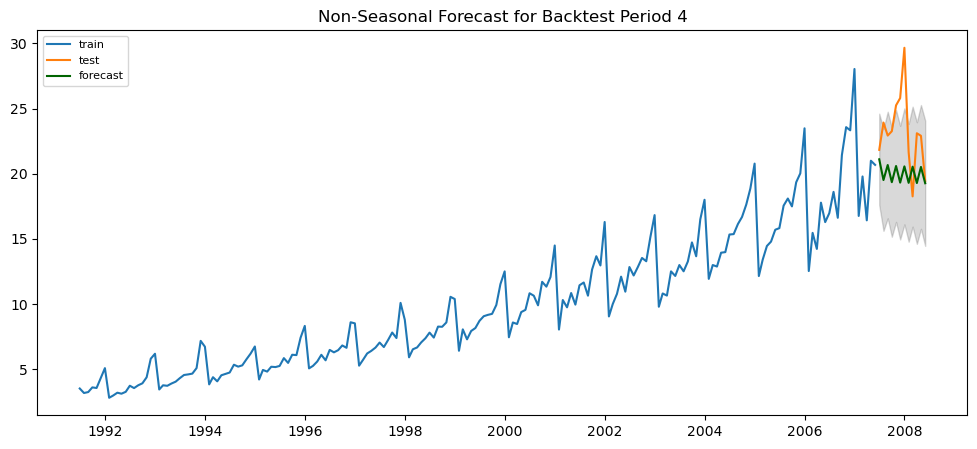

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=422.169, Time=0.52 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=505.309, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=440.957, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=422.766, Time=0.22 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=423.219, Time=0.05 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=423.200, Time=0.48 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=421.304, Time=0.85 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=420.235, Time=1.80 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=422.207, Time=2.14 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=420.588, Time=1.30 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=420.770, Time=1.52 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=435.856, Time=1.08 sec
 ARIMA(2,1,1)(1,1,2)[12]             : AIC=420.069, Time=2.37 sec
 ARIMA(2,1,1)(0,1,2)[12]             : AIC=420.743, Time=1.47 sec
 ARIMA(2,1,1)(1,1,1)[12]         

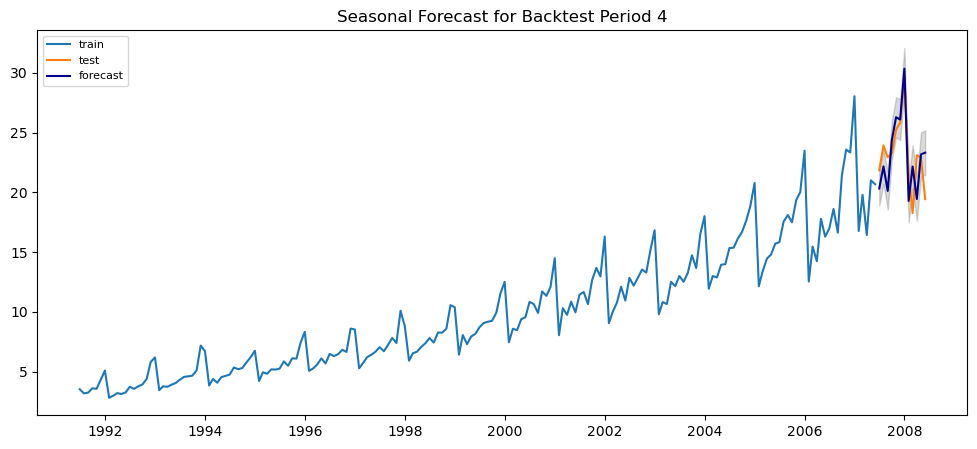

Test Predictions for Backtest Period 4:
                value  auto_nonseasonal_pred  auto_seasonal_pred   avg_pred
date                                                                       
2007-07-01  21.834890              21.107288           20.320117  20.713703
2007-08-01  23.930204              19.519602           22.168208  20.843905
2007-09-01  22.930357              20.670845           20.120670  20.395758
2007-10-01  23.263340              19.354537           24.361906  21.858221
2007-11-01  25.250030              20.595252           26.282020  23.438636
2007-12-01  25.806090              19.320138           26.089827  22.704982
2008-01-01  29.665356              20.567011           30.348311  25.457661
2008-02-01  21.654285              19.302876           19.278670  19.290773
2008-03-01  18.264945              20.545009           22.159049  21.352029
2008-04-01  23.107677              19.287862           19.444957  19.366409
2008-05-01  22.912510              20.523852    

Model      RMSE       MAE       MAPE     Backtest_Period
4       Auto ARIMA Seasonal  1.154635  0.985713   5.626410  2005-07 to 2006-06
1       Auto ARIMA Seasonal  1.147896  1.014923   6.306303  2004-07 to 2005-06
2                   Average  2.093743  1.739254  10.289303  2004-07 to 2005-06
5                   Average  2.203465  1.774894   9.696685  2005-07 to 2006-06
10      Auto ARIMA Seasonal  2.336601  1.938966   9.005322  2007-07 to 2008-06
7       Auto ARIMA Seasonal  2.615161  2.343003  11.295682  2006-07 to 2007-06
11                  Average  2.637884  2.448825  10.561479  2007-07 to 2008-06
0   Auto ARIMA Non Seasonal  3.192067  2.562634  14.941777  2004-07 to 2005-06
3   Auto ARIMA Non Seasonal  3.413987  2.675261  14.452221  2005-07 to 2006-06
8                   Average  3.627453  3.045024  13.937607  2006-07 to 2007-06
9   Auto ARIMA Non Seasonal  4.261563  3.545345  14.480971  2007-07 to 2008-06
6   Auto ARIMA Non Seasonal  4.879775  3.747045  16.579533  2006-07 to 2007-06

In [80]:
# Example usage:
backtest_periods = [
    ("2004-07", "2005-06"),
    ("2005-07", "2006-06"),
    ("2006-07", "2007-06"),
    ("2007-07", "2008-06")
]

# Run the backtest
arima_metrics_dataframe = backtest_auto_arima(drug_sales_df, backtest_periods)

# Sort by MAE (or any other metric)
arima_metrics_dataframe.sort_values(by='MAE')

## 4. Create a plot to show how various models performed against test data points in the back test periods

### ETS Metrics

In [83]:
# Modify the function to accept backtest_periods directly
def exponential_smoothing_backtest(train_data, test_data, backtest_periods):
    all_metrics = []  # To store metrics for all periods
    
    # Iterate over each backtest period
    for train_end, test_start, test_end in backtest_periods:  # Unpack the 3 elements in the tuple
        # Slice train and test data for the current backtest period
        train_period = train_data[:train_end]  # Using slices correctly
        test_period = test_data[test_start:test_end]
        
        forecast_period = len(test_period)  # Dynamically determine forecast length
        
        # Single Exponential Smoothing
        ins1 = SimpleExpSmoothing(train_period).fit(smoothing_level=0.2, optimized=False)
        ins2 = SimpleExpSmoothing(train_period).fit(smoothing_level=0.5, optimized=False)
        ins3 = SimpleExpSmoothing(train_period).fit()

        ins_cast1 = ins1.forecast(forecast_period).rename('alpha=0.2')
        ins_cast2 = ins2.forecast(forecast_period).rename('alpha=0.5')
        ins_cast3 = ins3.forecast(forecast_period).rename(f'alpha={ins3.model.params["smoothing_level"]:.2f}')


        # Double Exponential Smoothing
        double_ets_add = ExponentialSmoothing(train_period, trend='add').fit()
        double_ets_mul = ExponentialSmoothing(train_period, trend='mul').fit()

        double_ets_add_pred = double_ets_add.forecast(forecast_period)
        double_ets_mul_pred = double_ets_mul.forecast(forecast_period)


        # Triple Exponential Smoothing (Holt-Winters)
        triple_ets_add = ExponentialSmoothing(train_period, trend='add', seasonal='add', seasonal_periods=12).fit()
        triple_ets_mul = ExponentialSmoothing(train_period, trend='mul', seasonal='mul', seasonal_periods=12).fit()

        triple_ets_add_pred = triple_ets_add.forecast(forecast_period)
        triple_ets_mul_pred = triple_ets_mul.forecast(forecast_period)

        # Define metrics function
        def metrics_cal(actuals, predictions, model):
            mse = mean_squared_error(actuals, predictions)
            rmse = sqrt(mse)
            mae = mean_absolute_error(actuals, predictions)
            mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100

            return pd.DataFrame({
                'Model': [model],
                'RMSE': [rmse],
                'MAE': [mae],
                'MAPE': [mape],
                'Backtest_Period': [f'{test_start} to {test_end}']
            })

        # Compute metrics for this period
        actual_values = test_period.values.flatten()
        period_metrics = pd.concat([
            metrics_cal(actual_values, ins_cast1.values.flatten(), 'Simple 0.2'),
            metrics_cal(actual_values, ins_cast2.values.flatten(), 'Simple 0.5'),
            metrics_cal(actual_values, ins_cast3.values.flatten(), f"Simple {ins3.model.params['smoothing_level']:.2f}"),
            metrics_cal(actual_values, double_ets_add_pred.values.flatten(), 'Double Add'),
            metrics_cal(actual_values, double_ets_mul_pred.values.flatten(), 'Double Mul'),
            metrics_cal(actual_values, triple_ets_add_pred.values.flatten(), 'Triple Add'),
            metrics_cal(actual_values, triple_ets_mul_pred.values.flatten(), 'Triple Mul')
        ], ignore_index=True)
        
        # Append this period's metrics to the all_metrics list
        all_metrics.append(period_metrics)

    # Combine metrics for all periods into a single DataFrame
    final_metrics_df = pd.concat(all_metrics, ignore_index=True)
    
    # Sort by MAE
    return final_metrics_df.sort_values(by='MAE')

# Define backtest periods with start and end dates
backtest_periods = [
    ('2004-06', '2004-07', '2005-06'),  # train_end, test_start, test_end for the first period
    ('2005-06', '2005-07', '2006-06'),  # train_end, test_start, test_end for the second period
    ('2006-06', '2006-07', '2007-06'),  # and so on
    ('2007-06', '2007-07', '2008-06')
]

# Assuming drug_sales_df is your DataFrame with a DateTimeIndex and 'value' column
# Call the exponential_smoothing_backtest function
ets_metrics_df = exponential_smoothing_backtest(drug_sales_df['value'], drug_sales_df['value'], backtest_periods)

# Optionally, sort the combined metrics DataFrame by MAE or any other metric
ets_metrics_df = ets_metrics_df.sort_values(by='MAE')

# Display the final DataFrame with metrics for all backtest periods
ets_metrics_df


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be use

Model      RMSE       MAE       MAPE     Backtest_Period
6    Triple Mul  0.620139  0.500335   3.258752  2004-07 to 2005-06
13   Triple Mul  0.935307  0.860341   5.247795  2005-07 to 2006-06
5    Triple Add  1.041147  0.933409   5.843408  2004-07 to 2005-06
12   Triple Add  1.122216  0.987610   5.665812  2005-07 to 2006-06
27   Triple Mul  1.998244  1.616817   7.383933  2007-07 to 2008-06
20   Triple Mul  2.018214  1.789434   8.742747  2006-07 to 2007-06
26   Triple Add  2.174516  1.863363   8.537841  2007-07 to 2008-06
4    Double Mul  2.411873  1.961102  12.448462  2004-07 to 2005-06
3    Double Add  2.532282  1.999902  12.092792  2004-07 to 2005-06
19   Triple Add  2.434020  2.165085  10.456240  2006-07 to 2007-06
10   Double Add  2.902854  2.303359  13.254271  2005-07 to 2006-06
11   Double Mul  2.916421  2.309960  13.994932  2005-07 to 2006-06
2   Simple 0.24  3.096008  2.476756  14.466126  2004-07 to 2005-06
1    Simple 0.5  3.109151  2.489451  14.538088  2004-07 to 2005-06
0    Simple 0.2  3.112878  2.493040  14.558432  2004-07 to 2005-06
25   Double Mul  3.298603  2.576589  10.960420  2007-07 to 2008-06
18   Double Mul  3.484365  2.596247  12.153467  2006-07 to 2007-06
7    Simple 0.2  3.381749  2.649993  14.344632  2005-07 to 2006-06
9   Simple 0.28  3.432045  2.706090  14.631410  2005-07 to 2006-06
8    Simple 0.5  3.485984  2.764694  14.931002  2005-07 to 2006-06
17   Double Add  3.840684  2.931650  13.278898  2006-07 to 2007-06
24   Double Add  3.601454  2.946251  12.280881  2007-07 to 2008-06
22   Simple 0.5  4.110187  3.426282  13.974314  2007-07 to 2008-06
23  Simple 0.31  4.139540  3.453203  14.079687  2007-07 to 2008-06
21   Simple 0.2  4.211767  3.518746  14.336236  2007-07 to 2008-06
14   Simple 0.2  4.905221  3.620414  15.780736  2006-07 to 2007-06
16  Simple 0.25  4.966391  3.676336  16.036112  2006-07 to 2007-06
15   Simple 0.5  5.140457  3.875384  17.007811  2006-07 to 2007-06

### Combined ARIMA and ETS Metrics

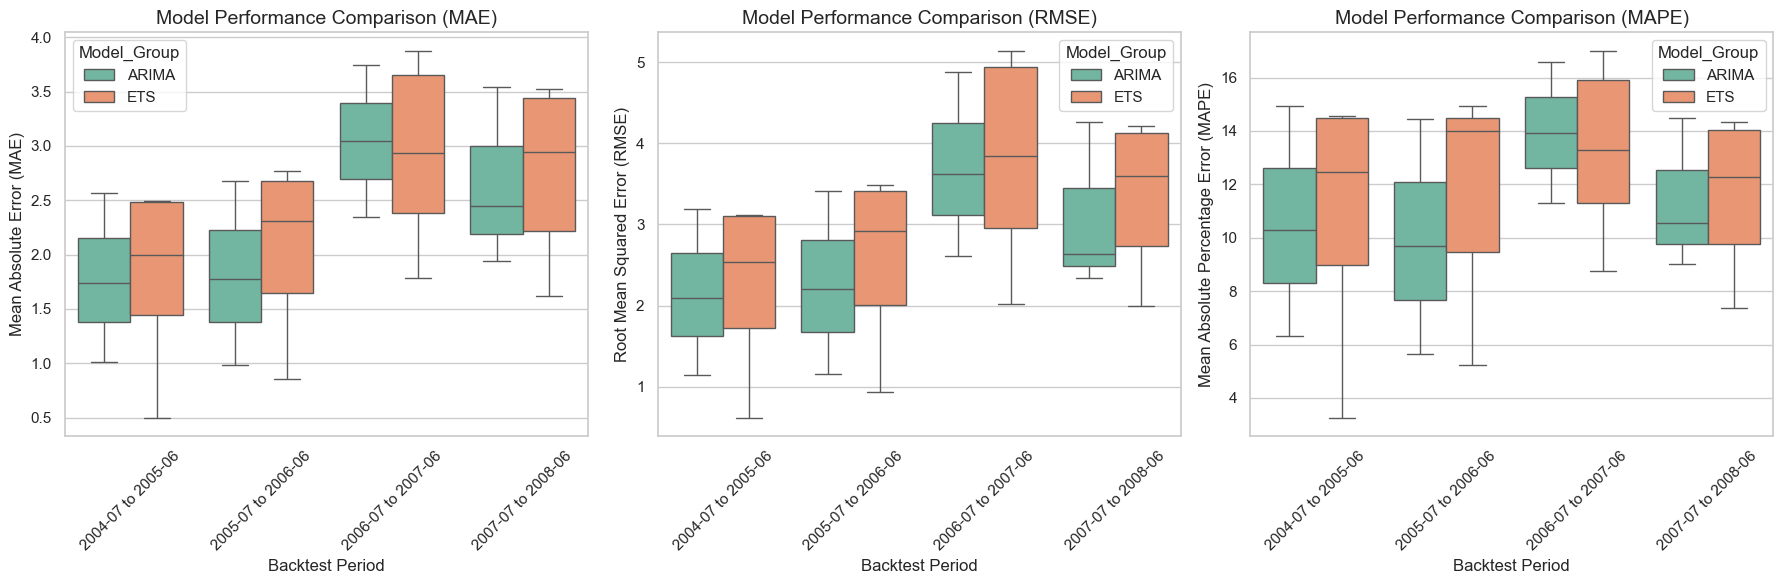

In [86]:
# Step 1: Add a 'Model_Group' column to differentiate between ETS and ARIMA models
arima_metrics_dataframe['Model_Group'] = 'ARIMA'
ets_metrics_df['Model_Group'] = 'ETS'

# Combine the two DataFrames (arima_metrics_dataframe and ets_metrics_df)
combined_metrics_df = pd.concat([arima_metrics_dataframe, ets_metrics_df], ignore_index=True)

# Ensure the Backtest_Period column is of the same format in both DataFrames
combined_metrics_df['Backtest_Period'] = combined_metrics_df['Backtest_Period'].astype(str)

# Step 2: Create plots for MAE, RMSE, and MAPE

# Set the plot style
sns.set(style="whitegrid")

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. MAE Plot
sns.boxplot(data=combined_metrics_df, x='Backtest_Period', y='MAE', hue='Model_Group', palette='Set2', ax=axes[0])
axes[0].set_title('Model Performance Comparison (MAE)', fontsize=14)
axes[0].set_xlabel('Backtest Period', fontsize=12)
axes[0].set_ylabel('Mean Absolute Error (MAE)', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)  # Rotate x labels for readability

# 2. RMSE Plot
sns.boxplot(data=combined_metrics_df, x='Backtest_Period', y='RMSE', hue='Model_Group', palette='Set2', ax=axes[1])
axes[1].set_title('Model Performance Comparison (RMSE)', fontsize=14)
axes[1].set_xlabel('Backtest Period', fontsize=12)
axes[1].set_ylabel('Root Mean Squared Error (RMSE)', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)  # Rotate x labels for readability

# 3. MAPE Plot
sns.boxplot(data=combined_metrics_df, x='Backtest_Period', y='MAPE', hue='Model_Group', palette='Set2', ax=axes[2])
axes[2].set_title('Model Performance Comparison (MAPE)', fontsize=14)
axes[2].set_xlabel('Backtest Period', fontsize=12)
axes[2].set_ylabel('Mean Absolute Percentage Error (MAPE)', fontsize=12)
axes[2].tick_params(axis='x', rotation=45)  # Rotate x labels for readability

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


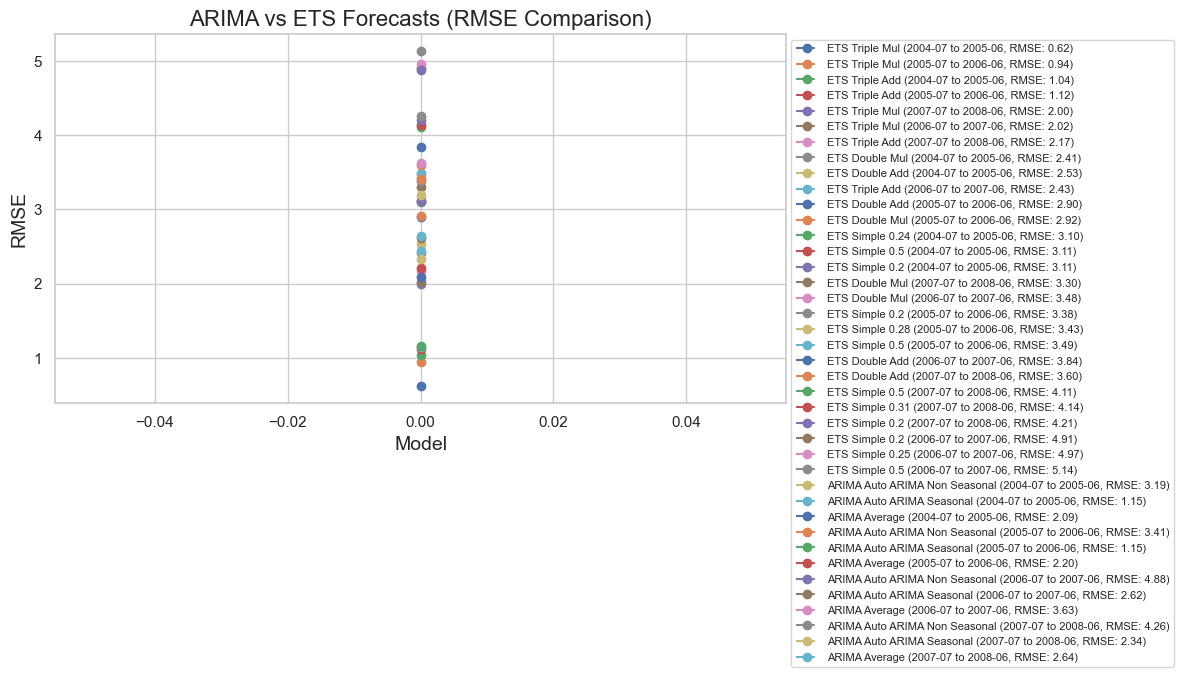

In [105]:
# Plot ARIMA and ETS metrics (only RMSE and Model for now)
plt.figure(figsize=(12, 6))

# Plot ETS models
for _, row in ets_metrics_df.iterrows():
    plt.plot([row['RMSE']], label=f"ETS {row['Model']} ({row['Backtest_Period']}, RMSE: {row['RMSE']:.2f})", marker='o', linestyle='--')

# Plot ARIMA models
for _, row in arima_metrics_dataframe.iterrows():
    plt.plot([row['RMSE']], label=f"ARIMA {row['Model']} ({row['Backtest_Period']}, RMSE: {row['RMSE']:.2f})", marker='o', linestyle='--')

# Title and Labels
plt.title('ARIMA vs ETS Forecasts (RMSE Comparison)', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('RMSE', fontsize=14)

# Adjust plot to fit everything nicely
plt.legend(loc='upper left', fontsize=8, bbox_to_anchor=(1, 1))
plt.tight_layout()

# Show the plot
plt.show()

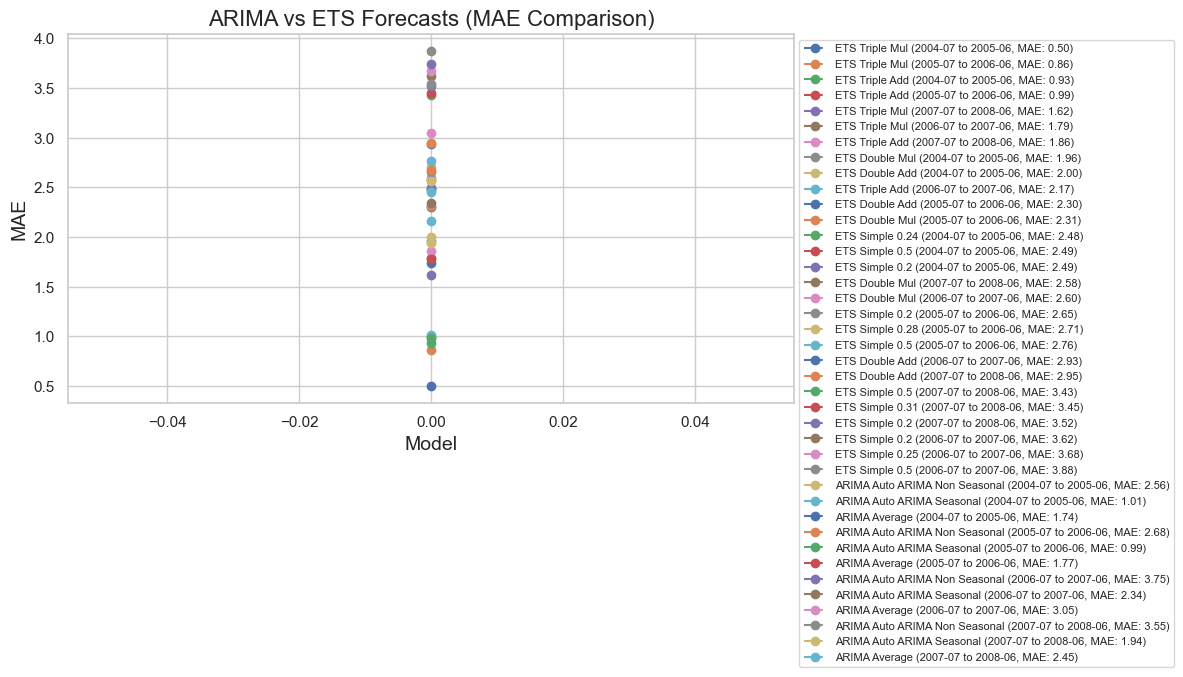

In [106]:
# Plot ARIMA and ETS metrics (MAE Comparison)
plt.figure(figsize=(12, 6))

# Plot ETS models for MAE
for _, row in ets_metrics_df.iterrows():
    plt.plot([row['MAE']], label=f"ETS {row['Model']} ({row['Backtest_Period']}, MAE: {row['MAE']:.2f})", marker='o', linestyle='--')

# Plot ARIMA models for MAE
for _, row in arima_metrics_dataframe.iterrows():
    plt.plot([row['MAE']], label=f"ARIMA {row['Model']} ({row['Backtest_Period']}, MAE: {row['MAE']:.2f})", marker='o', linestyle='--')

# Title and Labels
plt.title('ARIMA vs ETS Forecasts (MAE Comparison)', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('MAE', fontsize=14)

# Adjust plot to fit everything nicely
plt.legend(loc='upper left', fontsize=8, bbox_to_anchor=(1, 1))
plt.tight_layout()

# Show the plot
plt.show()


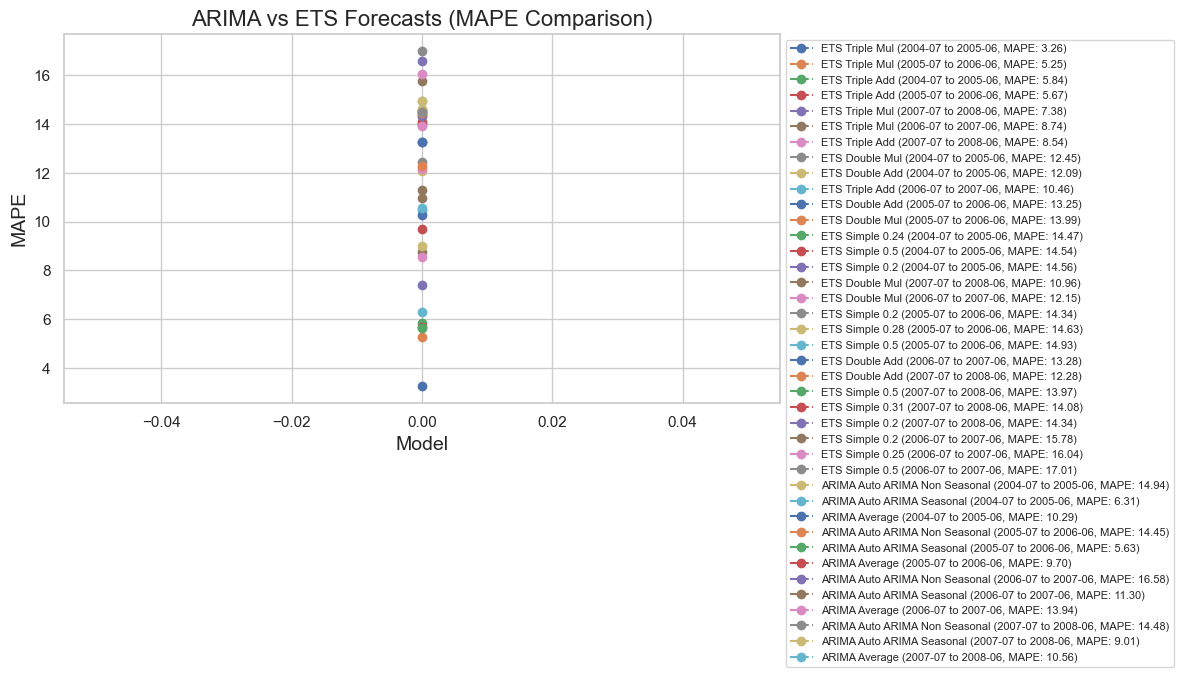

In [107]:
# Plot ARIMA and ETS metrics (MAPE Comparison)
plt.figure(figsize=(12, 6))

# Plot ETS models for MAPE
for _, row in ets_metrics_df.iterrows():
    plt.plot([row['MAPE']], label=f"ETS {row['Model']} ({row['Backtest_Period']}, MAPE: {row['MAPE']:.2f})", marker='o', linestyle='--')

# Plot ARIMA models for MAPE
for _, row in arima_metrics_dataframe.iterrows():
    plt.plot([row['MAPE']], label=f"ARIMA {row['Model']} ({row['Backtest_Period']}, MAPE: {row['MAPE']:.2f})", marker='o', linestyle='--')

# Title and Labels
plt.title('ARIMA vs ETS Forecasts (MAPE Comparison)', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('MAPE', fontsize=14)

# Adjust plot to fit everything nicely
plt.legend(loc='upper left', fontsize=8, bbox_to_anchor=(1, 1))
plt.tight_layout()

# Show the plot
plt.show()

## 5. Best model to predict the next 12 months

The best model to predict the next 12 months is the Triple Mul (ETS) model from the period 2004-07 to 2005-06. This model outperforms all ARIMA models across multiple metrics, including achieving the lowest RMSE (0.620139), MAE (0.500335), and MAPE (3.258752), which are critical indicators of forecasting accuracy. The ETS (Error-Trend-Seasonality) models, particularly the Triple Multiplicative variant, are well-suited for datasets exhibiting clear seasonal patterns, which is evident in the consistent performance of this model. The low RMSE and MAE demonstrate its precision in predicting values close to actual observations, while the low MAPE indicates that the relative percentage error is also minimized. Additionally, the Triple Mul model's ability to adjust for both trend and seasonality offers flexibility and robustness compared to other models, such as ARIMA, which may not perform as well when handling complex seasonal fluctuations. Given these factors, the Triple Mul ETS model is the most reliable for accurate and consistent long-term forecasting, especially over the next 12 months.